In [133]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import mplhep as hep
import datetime
hep.style.use('CMS')

import warnings
warnings.filterwarnings("ignore")

In [134]:
import os, sys

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from beamtest_analysis_helper import plot_BL_and_NW

/home/daq/ETROC2/ETROC-Analysis/TestBeam


## Load Run Info

In [135]:
run_time_df = pd.read_csv('./tb_run_info/DESY_Jun2024_TB_run_info.csv')
run_time_df.dropna(inplace=True)

run_time_df['Start_Time'] = run_time_df['Start_Time'] + ", 2024"
run_time_df['Start_Time'] = pd.to_datetime(run_time_df['Start_Time'])

run_time_df['Run'] = run_time_df['Run'].astype('uint8')
run_time_df = run_time_df.astype({col: 'uint16' for col in run_time_df.columns if col.startswith('HV')})
run_time_df = run_time_df.astype({col: 'uint8' for col in run_time_df.columns if col.startswith('offset')})

In [136]:
# Remove "hour" from Duration column
run_time_df['Duration'] = run_time_df['Duration'].str.replace('hour', '').str.strip()

# Directly add the duration to the Start_Time
run_time_df['Duration'] = run_time_df['Duration'].astype(float)
run_time_df['End_Time'] = run_time_df['Start_Time'] + pd.to_timedelta(run_time_df['Duration'], unit='h')

# Remove when Duration = 0
run_time_df = run_time_df.loc[run_time_df['Duration'] != 0]

In [137]:
run_time_df.tail()

Run          Start_Time  Duration Loop Time  HV0  HV1  HV2  HV3  offset0  \
90   90 2024-06-21 13:28:00       3.0    30 sec  260  120  120  270       20   
91   91 2024-06-21 17:00:00       3.0    30 sec  260  120  120  250       20   
92   92 2024-06-21 20:28:00       3.0    30 sec  260  120  120  220       20   
93   93 2024-06-22 00:08:00       3.0    30 sec  260  120  120  200       20   
94   94 2024-06-22 03:36:00       3.0    30 sec  260  120  120  180       20   

    offset1  offset2  offset3            End_Time  
90       20       20       20 2024-06-21 16:28:00  
91       20       20       20 2024-06-21 20:00:00  
92       20       20       20 2024-06-21 23:28:00  
93       20       20       10 2024-06-22 03:08:00  
94       20       20       10 2024-06-22 06:36:00

## Baseline plots

In [138]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/DESYJune2024/BaselineHistory.sqlite')

baseline_df = pd.read_sql_query("SELECT * from baselines", con)

baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
baseline_df['timestamp'] = baseline_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'])

In [139]:
baseline_df.tail()

col  row  baseline  noise_width           timestamp     chip_name
125179   11   15     188.0          5.0 2024-06-22 03:31:34  ET2p01_Pair1
125180   12   15     188.0          4.0 2024-06-22 03:31:34  ET2p01_Pair1
125181   13   15     192.0          4.0 2024-06-22 03:31:35  ET2p01_Pair1
125182   14   15     188.0          4.0 2024-06-22 03:31:35  ET2p01_Pair1
125183   15   15     202.0          5.0 2024-06-22 03:31:35  ET2p01_Pair1

In [140]:
### Add board names in the dictionary

config_dict = {
    'ET2p01_Bar4': {
        'plot_title': '(FBK UFSD4 W15) BAR_4',
        'chip_type': 'T',
        'channel': 0,
    },
    'ET2p01_Bar12': {
        'plot_title': 'BAR_12',
        'chip_type': 'T',
        'channel': 1,
    },
    'ET2p01_Bar13': {
        'plot_title': 'ET2p01_Bar13',
        'chip_type': 'T',
        'channel': 2,
    },
    'ET2p01_CNM13HPK': {
        'plot_title': '(HPK Split-3 W16 P6) BB_1-3',
        'chip_type': 'F',
        'channel': 3,
    },
    'ET2p01_Pair1': {
        'plot_title': '(FBK UFSD4) EPIR Pair 1',
        'chip_type': 'F',
        'channel': 3,
    },
}

### Make BL and NW map

In [141]:
# plot_BL_and_NW(run_time_df=run_time_df, which_run=60, baseline_df=baseline_df, config_dict=config_dict, which_val='baseline')

In [142]:
# plot_BL_and_NW(run_time_df=run_time_df, which_run=7, baseline_df=baseline_df, config_dict=config_dict, which_val='noise_width')

### Select data

In [143]:
# selected_baselines = defaultdict(pd.DataFrame)

# for index, row in run_time_df.iterrows():
#     cut_start_time = row['Start_Time'] - pd.Timedelta(minutes=30)
#     cut_end_time = row['End_Time'] + pd.Timedelta(minutes=10)

#     filtered_df = interest_df.loc[(interest_df['timestamp'] > cut_start_time) & (interest_df['timestamp'] < cut_end_time)]
#     selected_baselines[row['Run']] = filtered_df

In [144]:
# selected_baselines.keys()

### Baseline over time

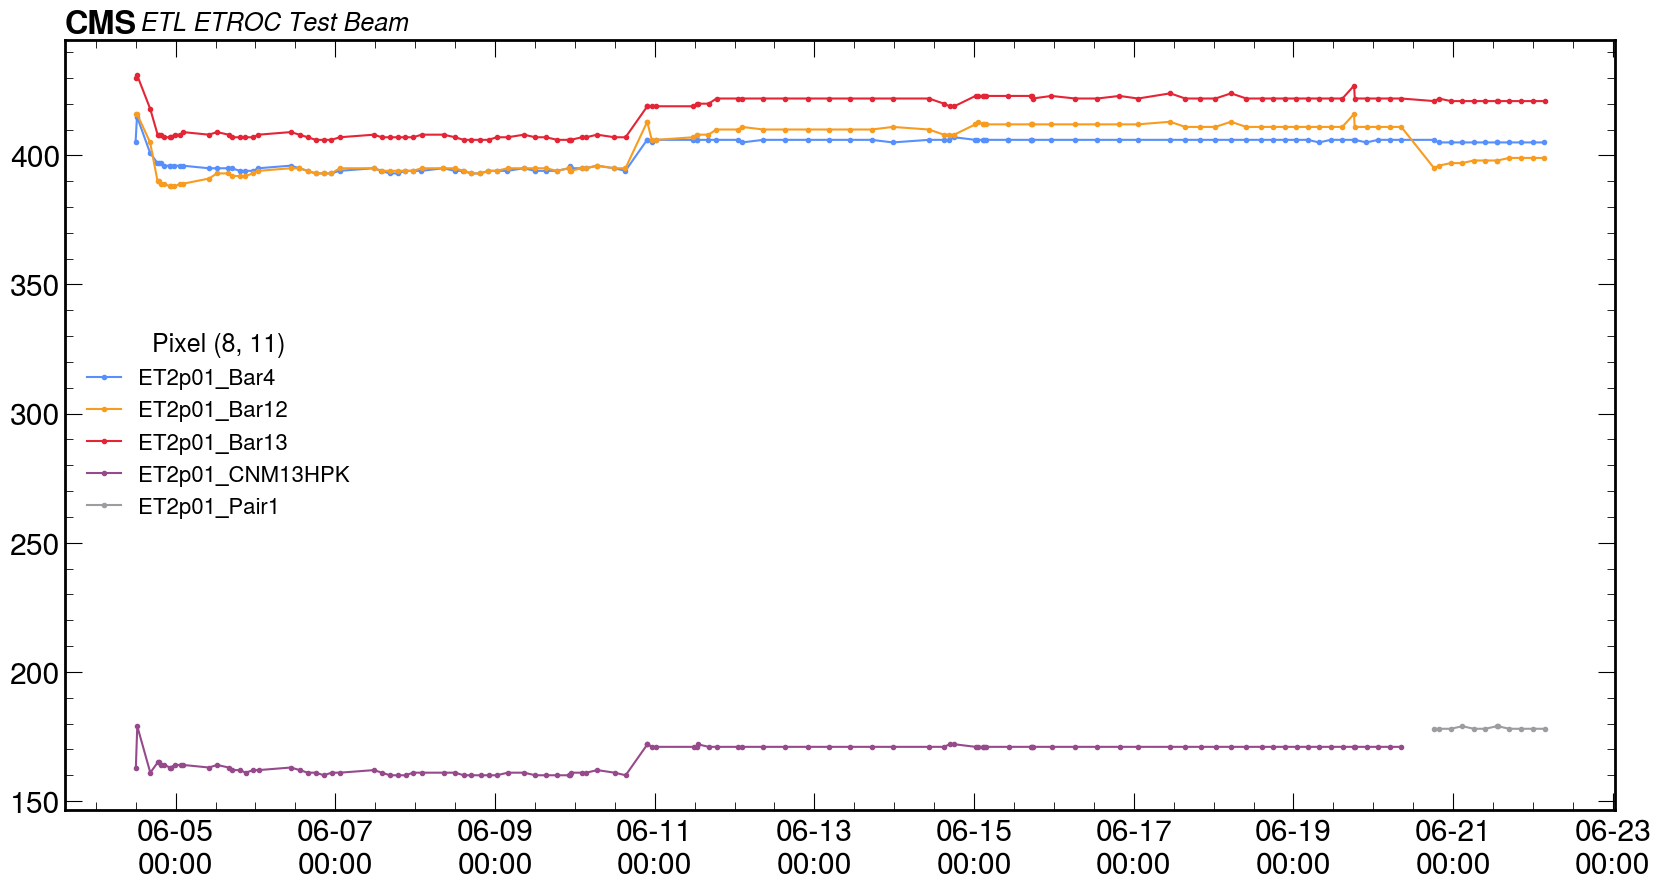

In [145]:
fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="ETL ETROC Test Beam", fontsize=18)
# ax.set_title('Baseline of pixel (8, 11)', size=18, loc="right")

date_form = mdates.DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_form)

cut_time = pd.to_datetime('2024-05-01 22:00:00')

interest_df = baseline_df.loc[(baseline_df['row'] == 8) & (baseline_df['col'] == 11)]

for iboard in interest_df['chip_name'].unique():
    tmp_df = interest_df.loc[interest_df['chip_name']==iboard]
    tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
    ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'{iboard}', marker='.')

text_y = [200, 370]
draw_dates = False

if draw_dates:
    for index, row in run_time_df.iterrows():

        if index%2 == 0:
            yval = text_y[0]
        else:
            yval = text_y[1]

        plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
        ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=yval, s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
        plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
        ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=yval, s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

ax.legend(loc='center left', fontsize=16, title='Pixel (8, 11)', title_fontsize=18)

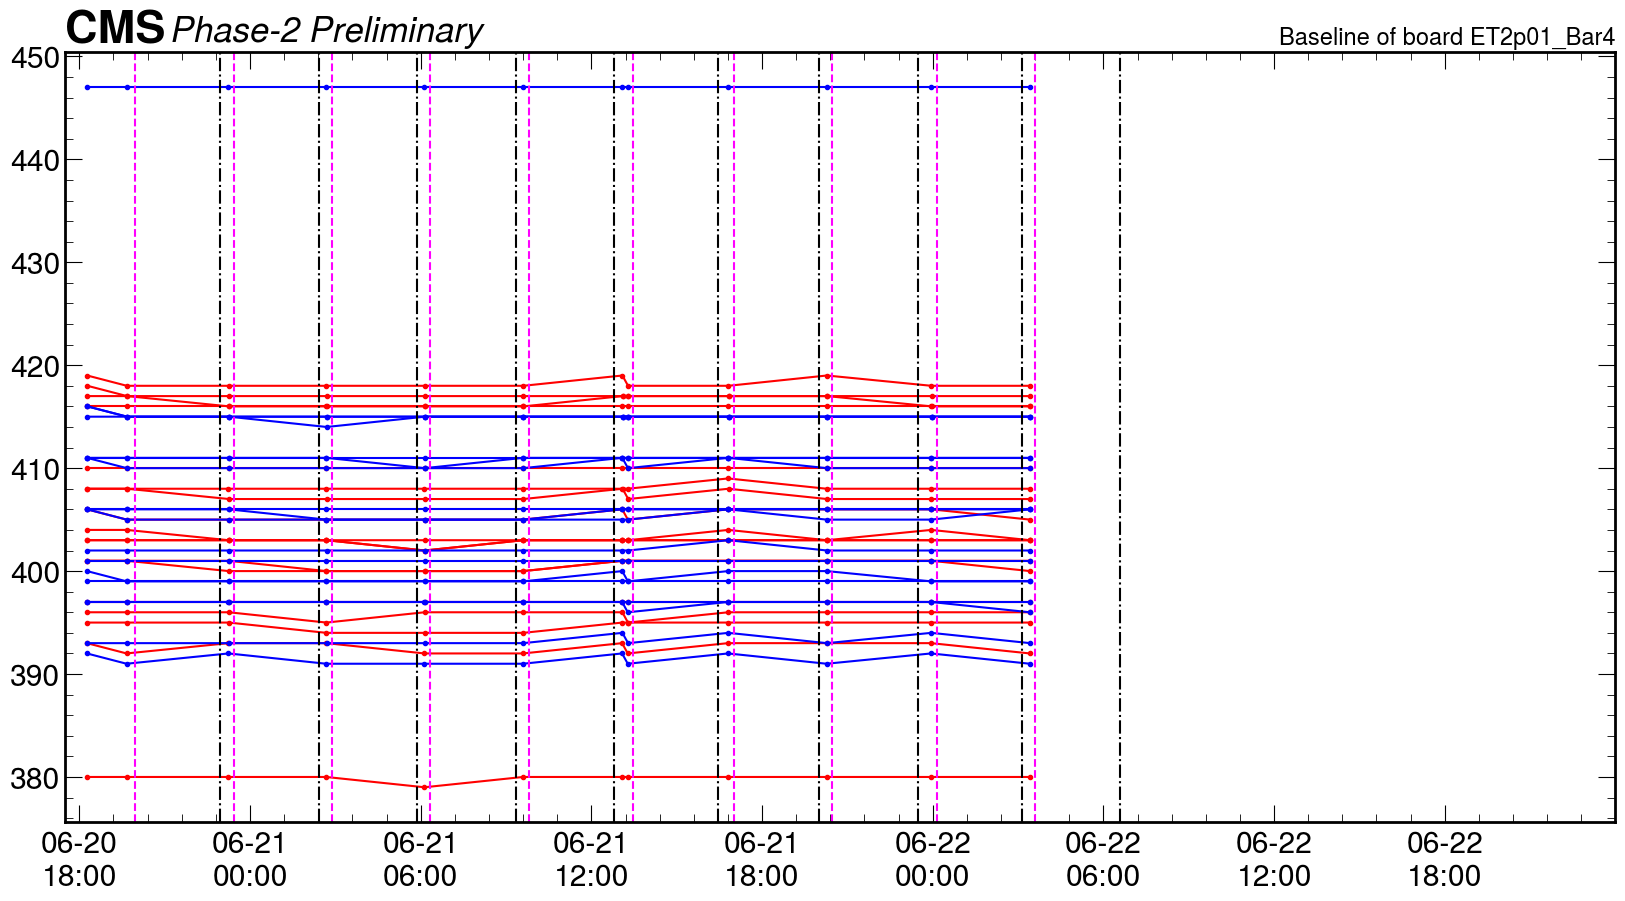

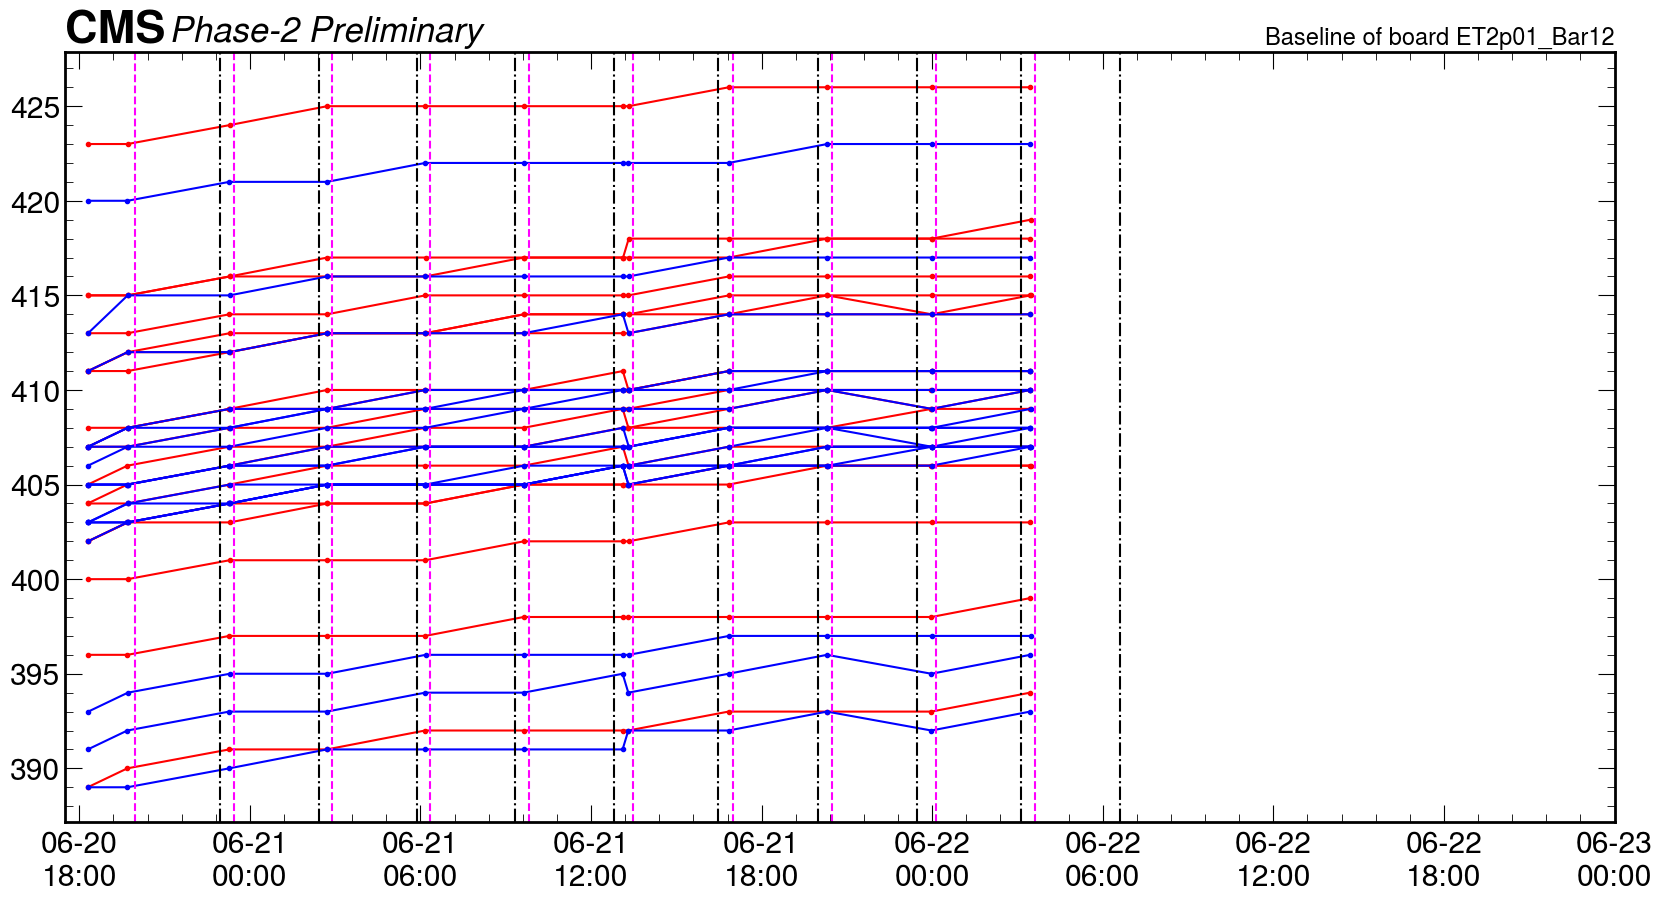

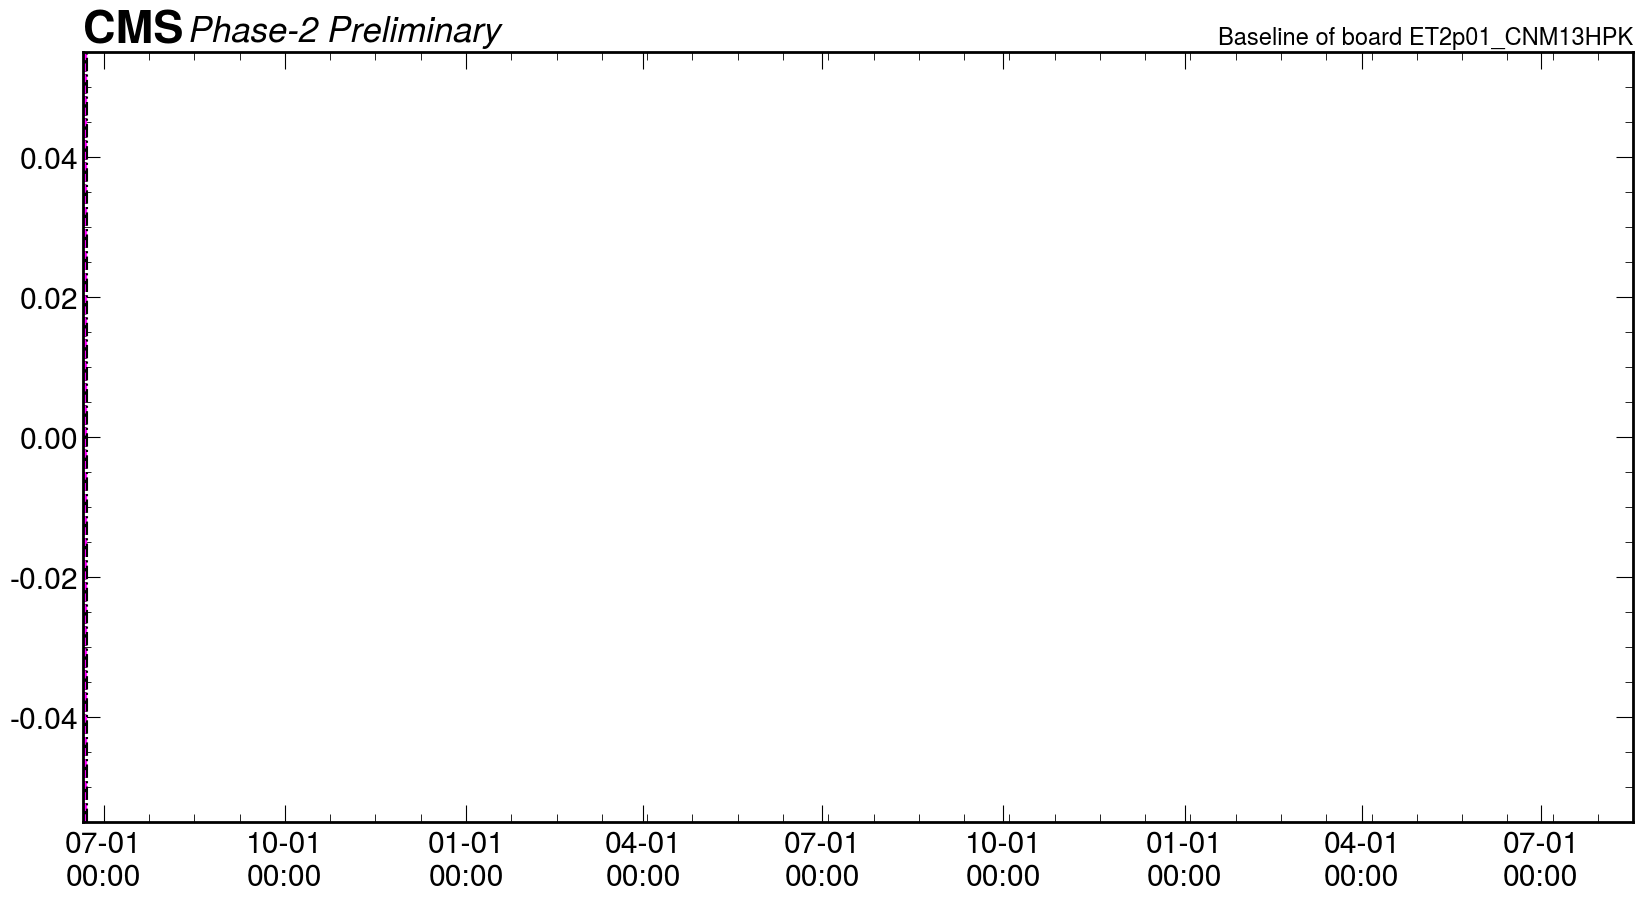

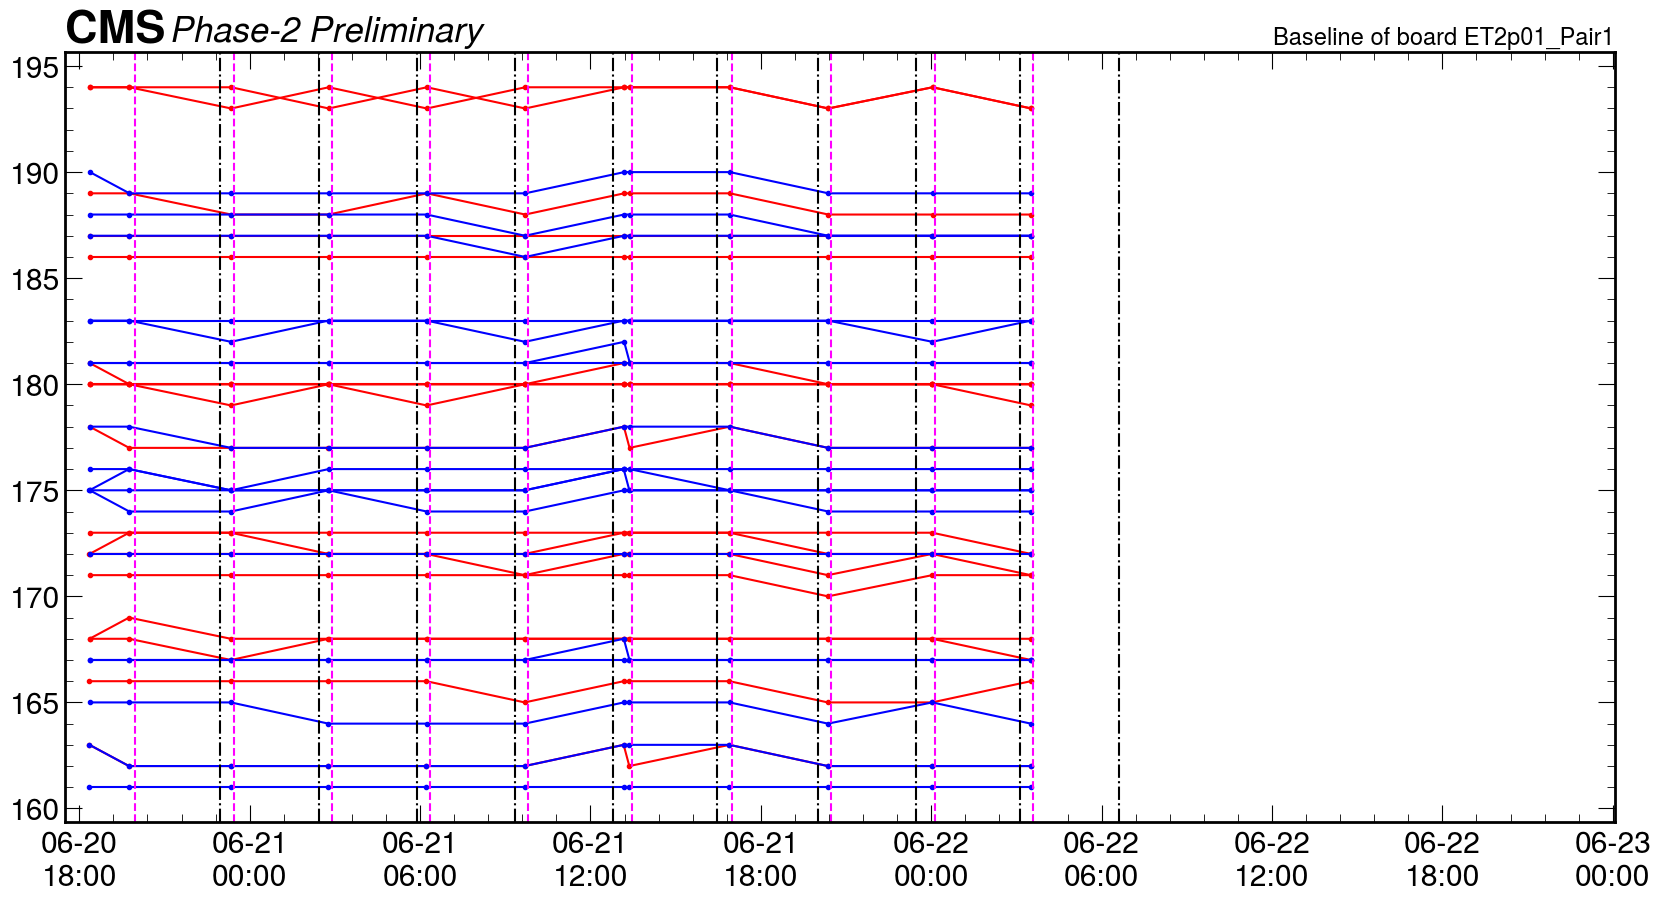

In [146]:
pixel_plot_list_row,pixel_plot_list_col = np.meshgrid([2, 5, 7, 8, 9, 13], [2, 5, 7, 8, 9, 13])
pixel_plot_list = list(zip(pixel_plot_list_row.flatten(),pixel_plot_list_col.flatten()))

draw_dates = True
cut_time = pd.to_datetime('2024-06-20 17:30:00')

for iboard in baseline_df['chip_name'].unique():
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
    ax.set_title(f'Baseline of board {iboard}', size=17, loc="right")
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    for row,col in pixel_plot_list:
        interest_df = baseline_df.loc[baseline_df['chip_name']==iboard]
        tmp_df = interest_df.loc[(interest_df['col']==col) & (interest_df['row']==row)].reset_index(drop=True)
        
        tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
        ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'Pixel R{row} C{col}', marker='.', c='r' if col<8 else 'b')

    if draw_dates:
        for index, row in run_time_df.iterrows():
            ax.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
            ax.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
    ax.set_xlim(left=cut_time)

## Temperature

In [147]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/DESYJune2024/ADCHistory.sqlite')

adc_df = pd.read_sql_query("SELECT * from adc", con)

In [148]:
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
adc_df['timestamp'] = adc_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'])
adc_df = adc_df.loc[adc_df['channel']!=0] # Remove bad data

In [149]:
adc_df.tail()

timestamp  ADC  channel   voltage  vref  calibrated  \
1445885 2024-06-22 03:32:16  935        1  0.570818   2.5    21.76732   
1445886 2024-06-22 03:32:16  859        3  0.524420   2.5         NaN   
1445887 2024-06-22 03:32:16  853        5  0.520757   2.5         NaN   
1445888 2024-06-22 03:32:16  960        7  0.586081   2.5         NaN   
1445889 2024-06-22 03:32:16  821        8  0.501221   2.5    25.75358   

        calibrated_units  
1445885                C  
1445886             None  
1445887             None  
1445888             None  
1445889                C

### Load TI HDC1080 Data

In [150]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/DESYJune2024/ti1080_sensor_data.sqlite')

ti_hdc1080_df = pd.read_sql_query("SELECT * from ti_hdc1080", con)
# ti_hdc1080_df['timestamp_unix'] = pd.to_datetime(ti_hdc1080_df['timestamp'], unit="ms", origin="unix")
ti_hdc1080_df['timestamp'] = pd.to_datetime(ti_hdc1080_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
ti_hdc1080_df['timestamp'] = ti_hdc1080_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
ti_hdc1080_df['timestamp'] = pd.to_datetime(ti_hdc1080_df['timestamp'])

In [151]:
ti_hdc1080_df.tail()

timestamp  temperature  humidity  which_hdc1080
120369 2024-06-22 03:31:38       25.219       0.0              1
120370 2024-06-22 03:31:48       25.208       0.0              1
120371 2024-06-22 03:31:58       25.208       0.0              1
120372 2024-06-22 03:32:08       25.219       0.0              1
120373 2024-06-22 03:32:18       25.219       0.0              1

(19894.583333333332, 19897.030702546297)

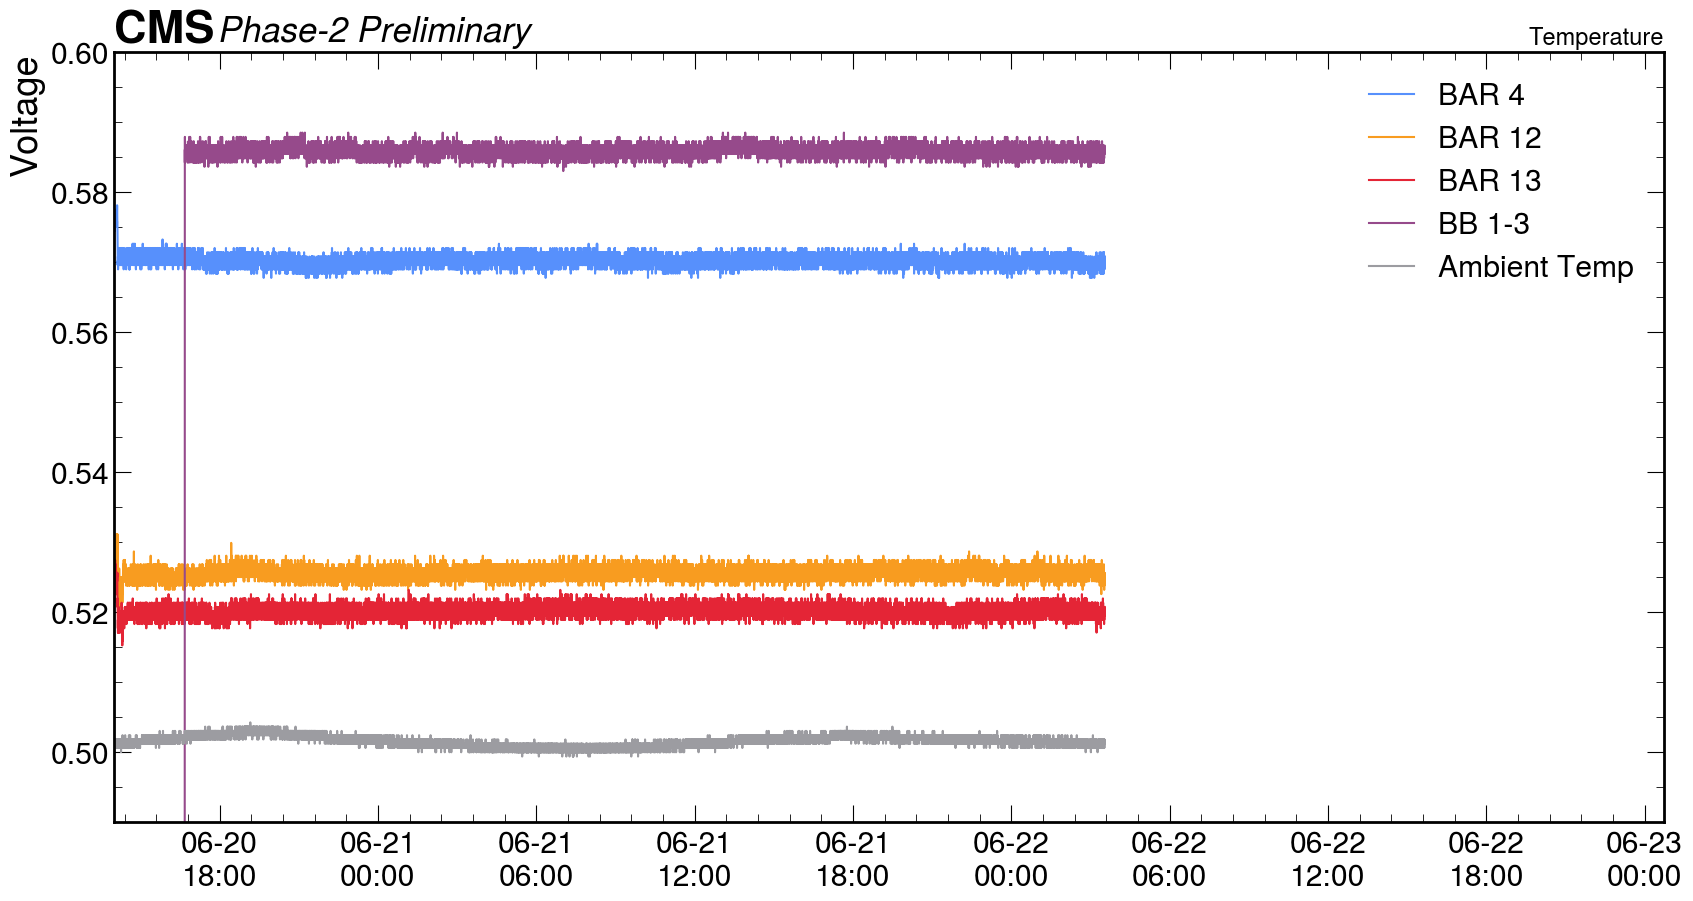

In [152]:
names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3', 'Ambient Temp']

fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
ax.set_title('Temperature', size=17, loc="right")
date_form = mdates.DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_form)

for idx, iboard in enumerate(sorted(adc_df['channel'].unique())):
    tmp_df = adc_df.loc[adc_df['channel']==iboard]
    ax.plot(tmp_df['timestamp'], tmp_df['voltage'], label=f'{names[idx]}')

text_y = [0.51, 0.55]
# for index, row in run_time_df.iterrows():

#     if index%2 == 0:
#         yval = text_y[0]
#     else:
#         yval = text_y[1]

#     plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
#     ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=yval, s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#     plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
#     ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=yval, s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

ax.legend(loc='best')
ax.set_ylabel('Voltage')
plt.ylim(bottom=0.49, top=.6)
plt.xlim(left=datetime.datetime(2024, 6, 20, 14, 0))

### VTemp per board

In [153]:
# names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3', 'Ambient Temp']
# draw_text_loc = [0.57, 0.534, 0.5325, .45, .499]
# draw_dates = True
# voltage_cut = 0.3

# for idx, iboard in enumerate(sorted(adc_df['channel'].unique())):
#     fig, ax = plt.subplots(figsize=(20, 10))
#     hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
#     ax.set_title(f'Board {names[idx]} Temperature', size=17, loc="right")
#     tmp_df = adc_df.loc[adc_df['channel']==iboard]
#     tmp_df = tmp_df.loc[tmp_df['voltage'] > voltage_cut]
#     ax.plot(tmp_df['timestamp'], tmp_df['voltage'], label=f'{names[idx]}')

#     date_form = mdates.DateFormatter("%m-%d\n%H:%M")
#     ax.xaxis.set_major_formatter(date_form)

#     if(False):
#         for index, row in run_time_df.iterrows():

#             plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
#             ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=draw_text_loc[idx], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#             plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
#             ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=draw_text_loc[idx], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

#     ax.legend(loc='best')
#     ax.set_ylabel('Voltage')
#     # ax.set_ylim(bottom=0.48, top=.6)

### Make Bar 4, TI HDC data together - Scatter

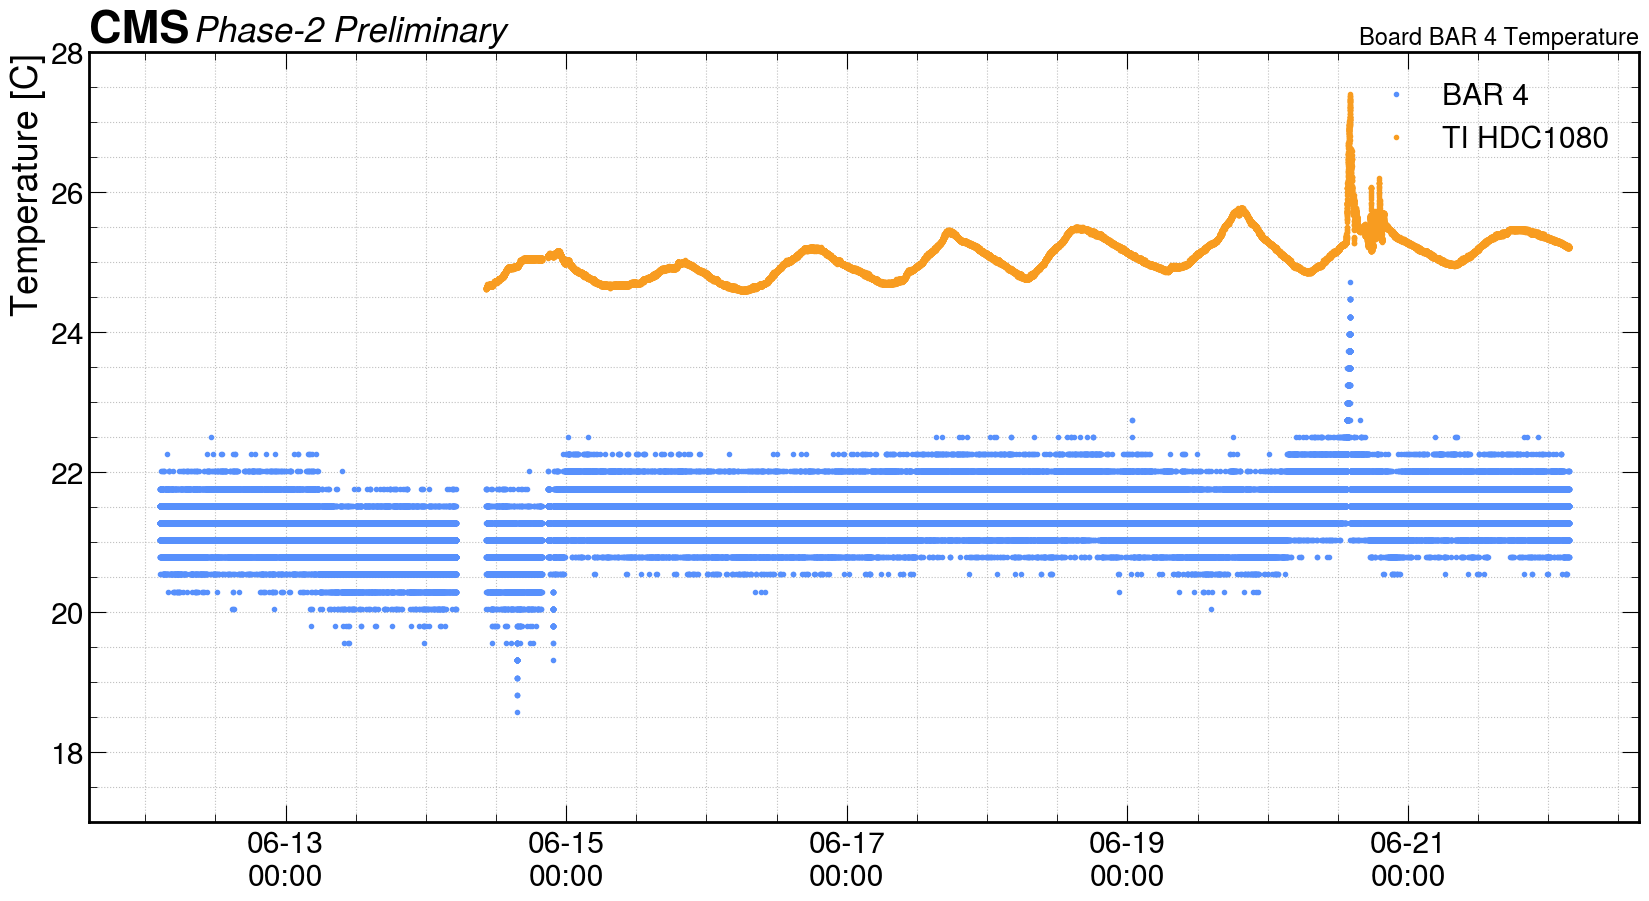

In [154]:
names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3', 'Ambient Temp']
# draw_text_loc = [20, 0.534, 0.5325, .45, .499]
draw_text_loc = [20, 37]
draw_dates = True

cut_time = pd.to_datetime('2024-06-04 12:30:00')
cut_time = datetime.datetime(2024, 6, 9, 12, 0)
cut_time = datetime.datetime(2024, 6, 11, 11, 0)
cut_time = datetime.datetime(2024, 6, 11, 18, 0)
cut_time = datetime.datetime(2024, 6, 12, 2, 30)
# cut_time = datetime.datetime(2024, 6, 11, 13, 0)

tmp_df = adc_df.loc[adc_df['channel']==1]
tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
tmp_hdc_df = ti_hdc1080_df.loc[ti_hdc1080_df['timestamp']>cut_time]

fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
ax.set_title(f'Board {names[0]} Temperature', size=17, loc="right")
date_form = mdates.DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_form)

ax.plot(tmp_df['timestamp'], (402.19*tmp_df['voltage']) - 207.81, ".", label=f'{names[0]}')
ax.plot(tmp_hdc_df['timestamp'], tmp_hdc_df['temperature'], ".", label='TI HDC1080')


# if(draw_dates):
#     for index, row in run_time_df.iterrows():

#         if index%2 == 0:
#             yval = draw_text_loc[0]
#         else:
#             yval = draw_text_loc[1]

#         plt.axvline(x=row['Start_Time'], ymin=0.15, ymax=0.7, color='magenta', linestyle='dashed')
#         ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=yval, s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#         plt.axvline(x=row['End_Time'], ymin=0.15, ymax=0.7, color='black', linestyle='dashdot')
#         ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=yval, s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

ax.legend(loc='best')
ax.set_ylabel('Temperature [C]')
# ax.set_xlim(left=datetime.datetime(2024, 6, 9, 12, 0))
ax.set_ylim(17,28)
ax.grid(which="both")

fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
ax.set_title(f'Board {names[0]} Temperature', size=17, loc="right")
ax.hist((402.19*tmp_df['voltage']) - 207.81, bins=50, range=(18,28), density=False, label=f'{names[0]}')
ax.legend(loc='best')
ax.set_ylabel('A.U.')
ax.grid(which="both")

# fig, ax = plt.subplots(figsize=(20, 10))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
# ax.set_title(f'Board {names[0]} Temperature', size=17, loc="right")
# # date_form = mdates.DateFormatter("%m-%d\n%H:%M")
# # ax.xaxis.set_major_formatter(date_form)
# ax.hist2d(x=pd.to_datetime(tmp_df['timestamp'],unit="s",origin="unix"),y=(402.19*tmp_df['voltage']) - 207.81, bins=[20], range=[[pd.to_datetime(datetime.datetime(2024, 6, 11, 13, 0),unit="s",origin="unix"),pd.to_datetime(datetime.datetime(2024, 6, 12, 1, 0),unit="s",origin="unix")],[18,28]], density=False)
# ax.legend(loc='best')
# ax.set_ylabel('A.U.')
# ax.grid(which="both")

In [155]:
ch1_df = adc_df.loc[adc_df['channel'] == 1]
ch1_df

timestamp  ADC  channel   voltage  vref  calibrated  \
0       2024-06-04 11:33:22  926        1  0.565324   2.5   19.557485   
5       2024-06-04 11:33:27  922        1  0.562882   2.5   18.575336   
10      2024-06-04 11:33:32  921        1  0.562271   2.5   18.329799   
15      2024-06-04 11:33:37  923        1  0.563492   2.5   18.820873   
20      2024-06-04 11:33:42  923        1  0.563492   2.5   18.820873   
...                     ...  ...      ...       ...   ...         ...   
1445865 2024-06-22 03:31:56  935        1  0.570818   2.5   21.767320   
1445870 2024-06-22 03:32:01  934        1  0.570208   2.5   21.521783   
1445875 2024-06-22 03:32:06  935        1  0.570818   2.5   21.767320   
1445880 2024-06-22 03:32:11  933        1  0.569597   2.5   21.276245   
1445885 2024-06-22 03:32:16  935        1  0.570818   2.5   21.767320   

        calibrated_units  
0                      C  
5                      C  
10                     C  
15                     C  
20                     C  
...                  ...  
1445865                C  
1445870                C  
1445875                C  
1445880                C  
1445885                C  

[288627 rows x 7 columns]

### Make Bar 4, TI HDC data together - Hist

In [156]:
# test = ch1_df.set_index('timestamp')['calibrated']
# grouped = test.groupby(pd.Grouper(freq='1min')).apply(list).reset_index()

In [157]:
# max_len = max(grouped['calibrated'].apply(len))
# data_matrix = np.full((len(grouped), max_len), np.nan)

# for i, values in enumerate(grouped['calibrated']):
#     data_matrix[i, :len(values)] = values

# data_matrix

In [158]:
# fig, ax = plt.subplots(figsize=(20, 10))
# hep.cms.text(loc=0, ax=ax, text="ETL ETROC Test Beam", fontsize=25)
# # ax.set_title(f'Board {names[0]} Temperature', size=17, loc="right")
# date_form = mdates.DateFormatter("%m-%d\n%H:%M")
# ax.xaxis.set_major_formatter(date_form)

# ax.imshow(data_matrix.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, len(grouped), 0, max_len])

## HV currents

In [159]:
# watch python3 scripts/logNICrate.py -o May6 -d /media/daq/X9/DESYJune2024/ETROC-History/HV_logging -t 3

In [160]:
# HV_json = '/media/daq/X9/DESYJune2024/ETROC-History/HV_logging/JunTB.json'
HV_json = '/home/daq/ETROC2/ETROC-History/DESYJune2024/HV_logging/JunTB.json'

In [161]:
df = pd.read_json(HV_json, lines=True)

In [162]:
def convert_voltage(series):
    multipliers = series.str.extract(r'(\d*\.\d+|\d+)( uV| mV| V)?', expand=True)
    multipliers[1] = multipliers[1].fillna('')
    multipliers[1] = multipliers[1].map({' uV': 1e-6, ' mV': 1e-3, ' V': 1, '': 1})
    return multipliers[0].astype('float32') * multipliers[1].astype('float32')

In [163]:
hv_info = defaultdict(pd.DataFrame)

# Extract columns for processing
channels = df['Channel'].apply(pd.Series)
sense_voltages = df['Measured Sense Voltage'].apply(pd.Series)
terminal_voltages = df['Measured Terminal Voltage'].apply(pd.Series)
currents = df['Measured Current'].apply(pd.Series).replace(' uA', '', regex=True).astype('float32')

for inum in channels.columns:
    senseV = convert_voltage(sense_voltages[inum])
    terminalV = convert_voltage(terminal_voltages[inum])

    new_df = pd.DataFrame({
        'timestamp': pd.to_datetime(df['timestamp']),
        'senseV': -1*senseV,
        'terminalV': -1*terminalV,
        'currents': currents[inum]
    })

    hv_info[inum] = new_df

    del new_df

In [164]:
hv_info[0].tail()

timestamp  senseV  terminalV  currents
520830 2024-06-22 03:32:13  -260.0     -260.0     -8.42
520831 2024-06-22 03:32:18  -260.0     -260.0     -8.42
520832 2024-06-22 03:32:19  -260.0     -260.0     -8.42
520833 2024-06-22 03:32:23  -260.0     -260.0     -8.43
520834 2024-06-22 03:32:24  -260.0     -260.0     -8.43

In [165]:
# names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3']

# fig, ax = plt.subplots(figsize=(30, 14))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

# date_form = mdates.DateFormatter("%m-%d")
# ax.xaxis.set_major_formatter(date_form)

# for idx, iname in enumerate(names):
#     ax.plot(hv_info[idx]['timestamp'], hv_info[idx]['currents'], label=iname)

# ax.legend(loc='best')
# ax.set_ylabel('HV Currents [uA]')

In [166]:
# names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3']

# fig, ax = plt.subplots(figsize=(30, 14))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

# for idx, iname in enumerate(names):
#     ax.plot(hv_info[idx]['terminalV'], hv_info[idx]['currents'], label=iname)

# ax.legend(loc='best')
# ax.set_ylabel('HV Currents [uA]')
# ax.set_xlabel('HV Setting [V]')
# ax.invert_xaxis()
# ax.invert_yaxis()

In [167]:
names = ['FBK Sensor, ET2.01 (BAR 4)','HPK Sensor, ET2.01 (BAR 12)','HPK Sensor, ET2.01 (BAR 13)','HPK Split 3 Sensor, ET2.0 (BB 1-3)']
lims  = [(11.75,9.75,11.5),(.3,.1,.175),(.3,.1,.175),(.6,.1,.2)]
idxs  = [0,1,2,3]
draw_dates = False

for idx, name, lim in zip(idxs, names, lims):
    if(idx!=0): continue
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC Test Beam", fontsize=25)

    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=name, color='k')

    # ax.legend(loc='best')
    ax.set_ylabel('HV Currents [uA]', fontsize=25)
    ax.set_ylim(top=lim[0], bottom=lim[1])
    ax.set_xlim(left=datetime.datetime(2024, 6, 4, 19, 00), right=datetime.datetime(2024, 6, 6, 12, 0))
    ax.set_title(name, loc="right")
    if(draw_dates):
        for index, row in run_time_df.iterrows():
            if row['Start_Time'] > pd.to_datetime('2024-06-06 13:00:00'):
                continue
            plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
            ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
            plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
            ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Onboard Temperature from VTemp [C]', color=color, fontsize=25)
    tmp_df = adc_df.loc[adc_df['channel']==sorted(adc_df['channel'].unique())[idx]]
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
    tmp_df = tmp_df.loc[tmp_df['timestamp']>pd.to_datetime('2024-06-04 17:00:00')]
    ax2.plot(tmp_df['timestamp'], (402.19*tmp_df['voltage']) - 207.81, label=f'{names[idx]}', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines["right"].set_color(color)
    ax2.set_ylim(20, 30)

    ax3 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines.right.set_position(("axes", 1.07))
    color = 'tab:orange'
    ax3.set_ylabel('Ambient Temperature in Suitcase [C]', color=color, fontsize=25)
    ax3.plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'], label=f'{names[idx]}', color=color, lw=3)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_color(color)
    ax3.set_ylim(20, 30)

    ax.grid()
    plt.tight_layout()
    plt.show()

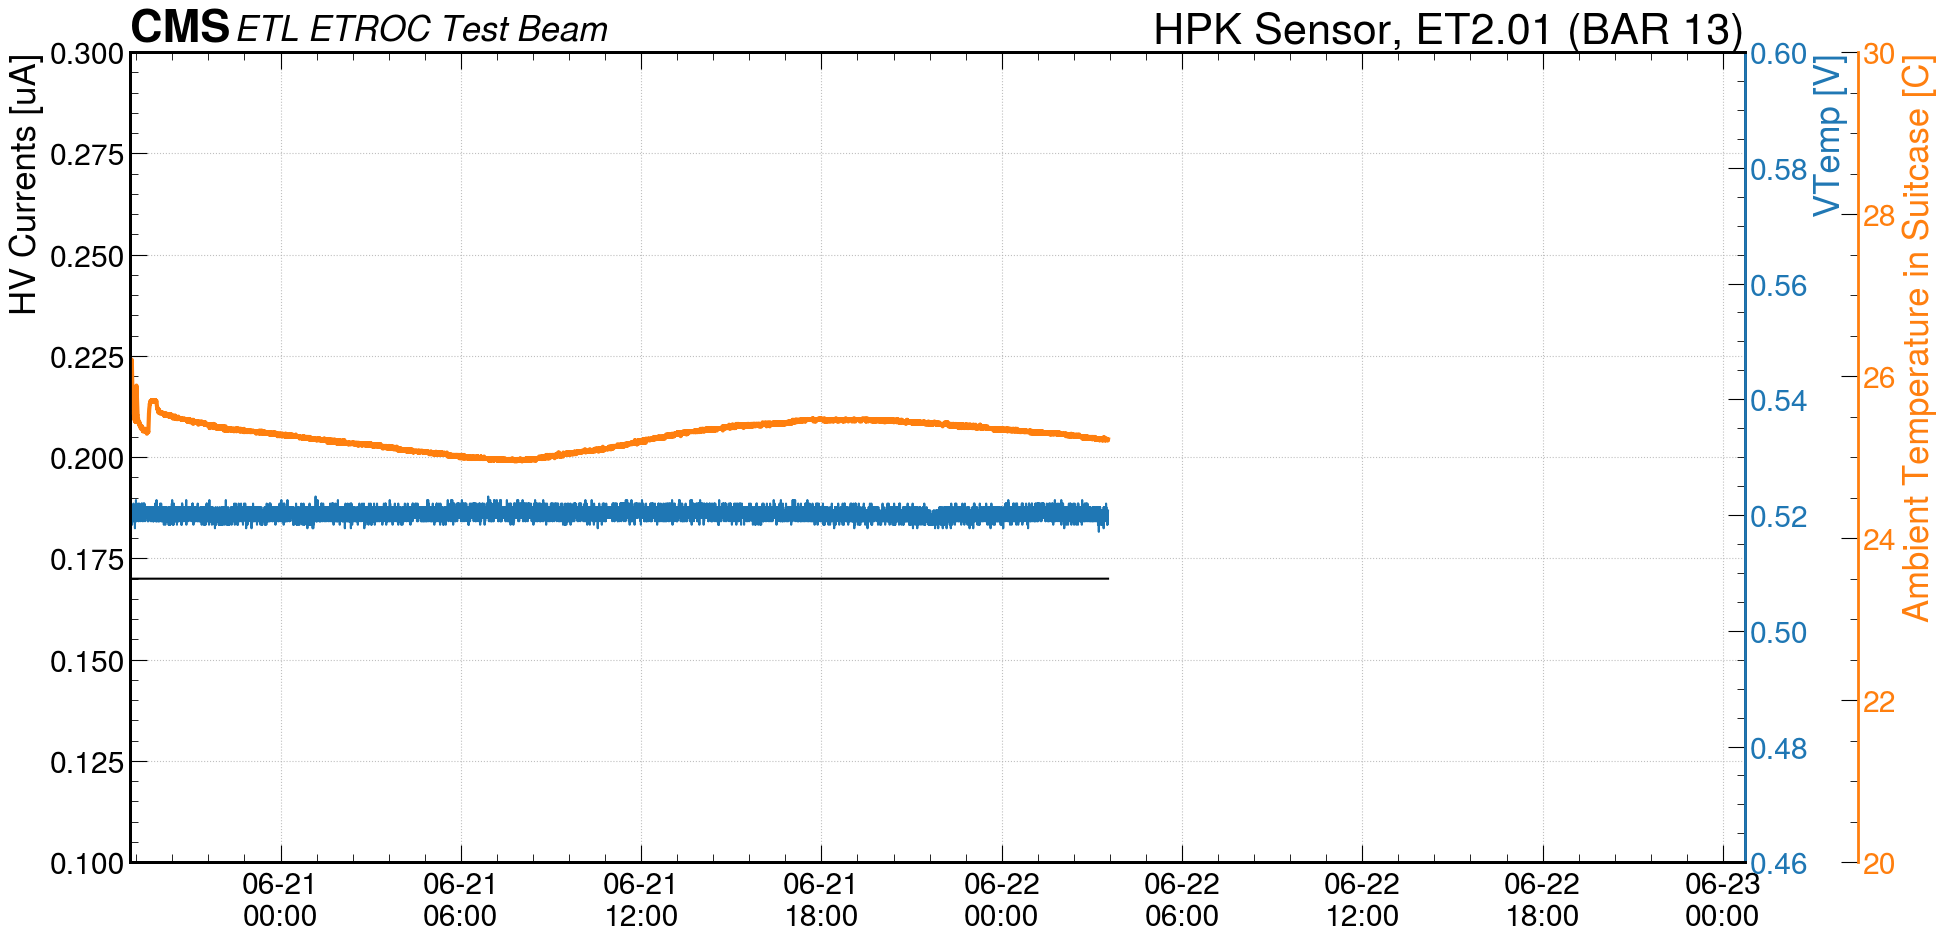

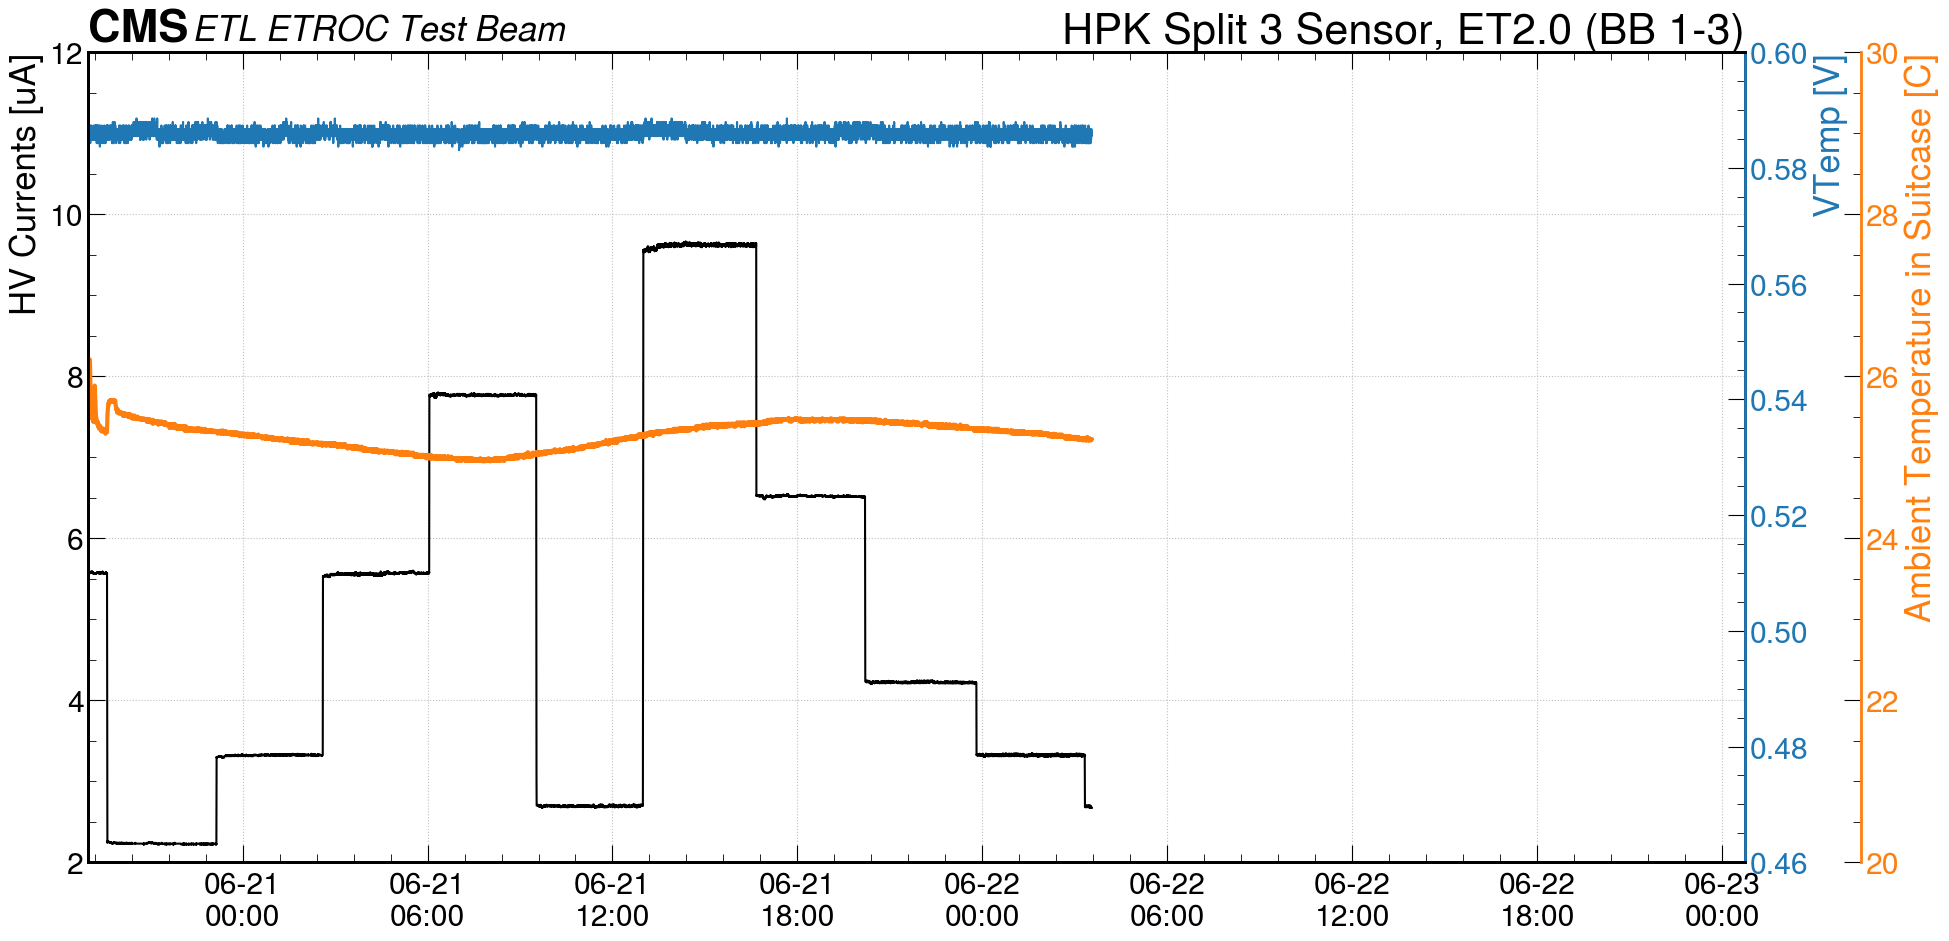

In [168]:
names = ['FBK Sensor, ET2.01 (BAR 4)','HPK Sensor, ET2.01 (BAR 12)','HPK Sensor, ET2.01 (BAR 13)','HPK Split 3 Sensor, ET2.0 (BB 1-3)']
lims  = [(11.75,9.75,11.5),(.3,.1,.175),(.3,.1,.175),(12,2,.2)]
idxs  = [0,1,2,3]
draw_dates = False
cut_time = datetime.datetime(2024, 6, 20, 19, 00)
for idx, name, lim in zip(idxs, names, lims):
    if(idx==0): continue
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC Test Beam", fontsize=25)

    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=name, color='k')

    # ax.legend(loc='best')
    ax.set_ylabel('HV Currents [uA]', fontsize=25)
    ax.set_ylim(top=lim[0], bottom=lim[1])
    # ax.set_xlim(left=datetime.datetime(2024, 6, 4, 19, 00), right=datetime.datetime(2024, 6, 6, 12, 0))

    ax.set_title(name, loc="right")
    if(draw_dates):
        for index, row in run_time_df.iterrows():
            if row['Start_Time'] > cut_time:
                continue
            plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
            ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
            plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
            ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('VTemp [V]', color=color, fontsize=25)
    tmp_df = adc_df.loc[adc_df['channel']==sorted(adc_df['channel'].unique())[idx]]
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
    # tmp_df = tmp_df.loc[tmp_df['timestamp']>pd.to_datetime('2024-06-04 17:00:00')]
    ax2.plot(tmp_df['timestamp'], tmp_df['voltage'], label=f'{names[idx]}', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines["right"].set_color(color)
    ax2.set_ylim(.46, .6)

    ax3 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines.right.set_position(("axes", 1.07))
    color = 'tab:orange'
    ax3.set_ylabel('Ambient Temperature in Suitcase [C]', color=color, fontsize=25)
    ax3.plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'], label=f'{names[idx]}', color=color, lw=3)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_color(color)
    ax3.set_ylim(20, 30)

    ax.set_xlim(left=cut_time)
    ax.grid()
    plt.tight_layout()
    plt.show()

In [169]:
# names = ['BAR 4']

# fig, ax = plt.subplots(figsize=(30, 14))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

# date_form = mdates.DateFormatter("%m-%d\n%H:%M")
# ax.xaxis.set_major_formatter(date_form)

# ax.plot(hv_info[0]['timestamp'], -1*hv_info[0]['currents'], label=names[0], color='k')

# ax.legend(loc='best')
# ax.set_ylabel('HV Currents [uA]')
# ax.set_ylim(top=25, bottom=1.5)
# ax.set_title(name, loc="right")

# if(draw_dates):
#     for index, row in run_time_df.iterrows():
#         plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
#         ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=12, s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#         plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
#         ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=12, s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

In [170]:
# names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3']

# fig, ax = plt.subplots(figsize=(30, 14))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

# date_form = mdates.DateFormatter("%m-%d")
# ax.xaxis.set_major_formatter(date_form)

# for idx, iname in enumerate(names):
#     if(idx==0): continue
#     ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=iname)

# ax.legend(loc='best')
# ax.set_ylabel('HV Currents [uA]')

# if(False):
#     for index, row in run_time_df.iterrows():
#         plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed')
#         ax.text(x=(row['Start_Time'] - pd.Timedelta(hours=1.2)), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
#         plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot')
#         ax.text(x=(row['End_Time'] + pd.Timedelta(minutes=15)), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

Text(1, 0, 'HV Setting [V]')

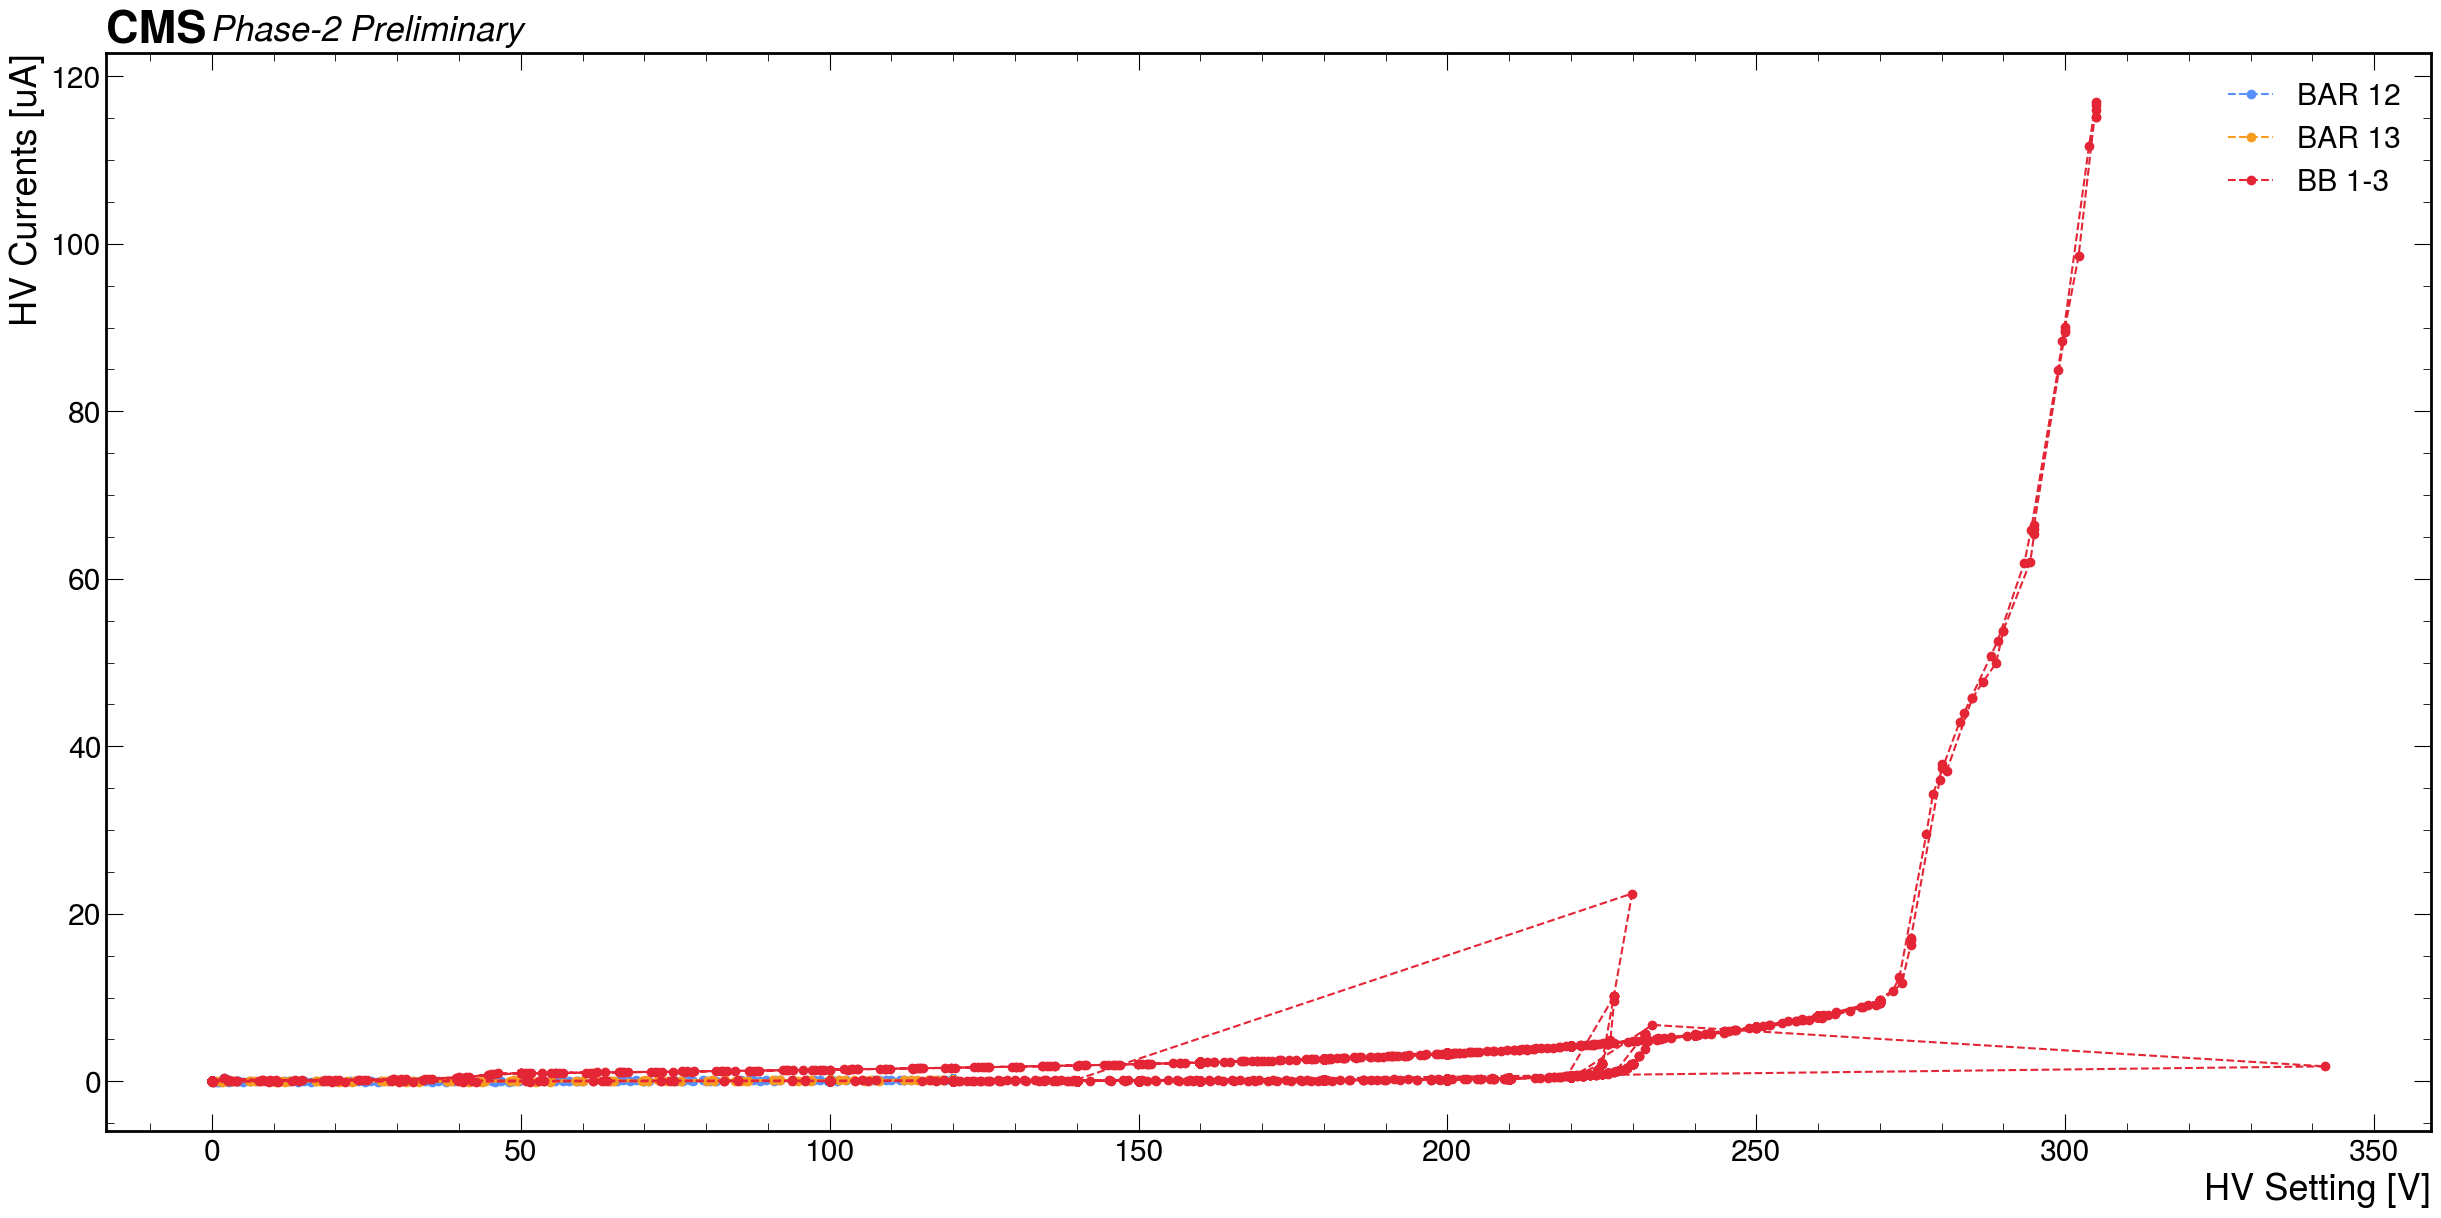

In [171]:
names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3']

fig, ax = plt.subplots(figsize=(30, 14))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

for idx, iname in enumerate(names):
    if(idx==0):continue
    ax.plot(-1*hv_info[idx]['terminalV'], -1*hv_info[idx]['currents'],"--o", label=iname)

ax.legend(loc='best')
ax.set_ylabel('HV Currents [uA]')
ax.set_xlabel('HV Setting [V]')

In [172]:
# name = 'FBK UFSD4 W15 2-3 with ETROC2.01 Chip (BAR 4)'

# cut_time = pd.to_datetime('2024-06-05 00:20:00')

# bar_4_df = hv_info[0]
# bar_4_df = bar_4_df.loc[bar_4_df['timestamp'] < cut_time]

# fig, ax = plt.subplots(figsize=(30, 14))
# hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

# ax.plot(-1*bar_4_df['terminalV'], -1*bar_4_df['currents'], "--o", label=name)

# ax.legend(loc='best')
# ax.set_ylabel('HV Currents [uA]')
# ax.set_xlabel('HV Setting [V]')

Text(1, 0, 'HV Setting [V]')

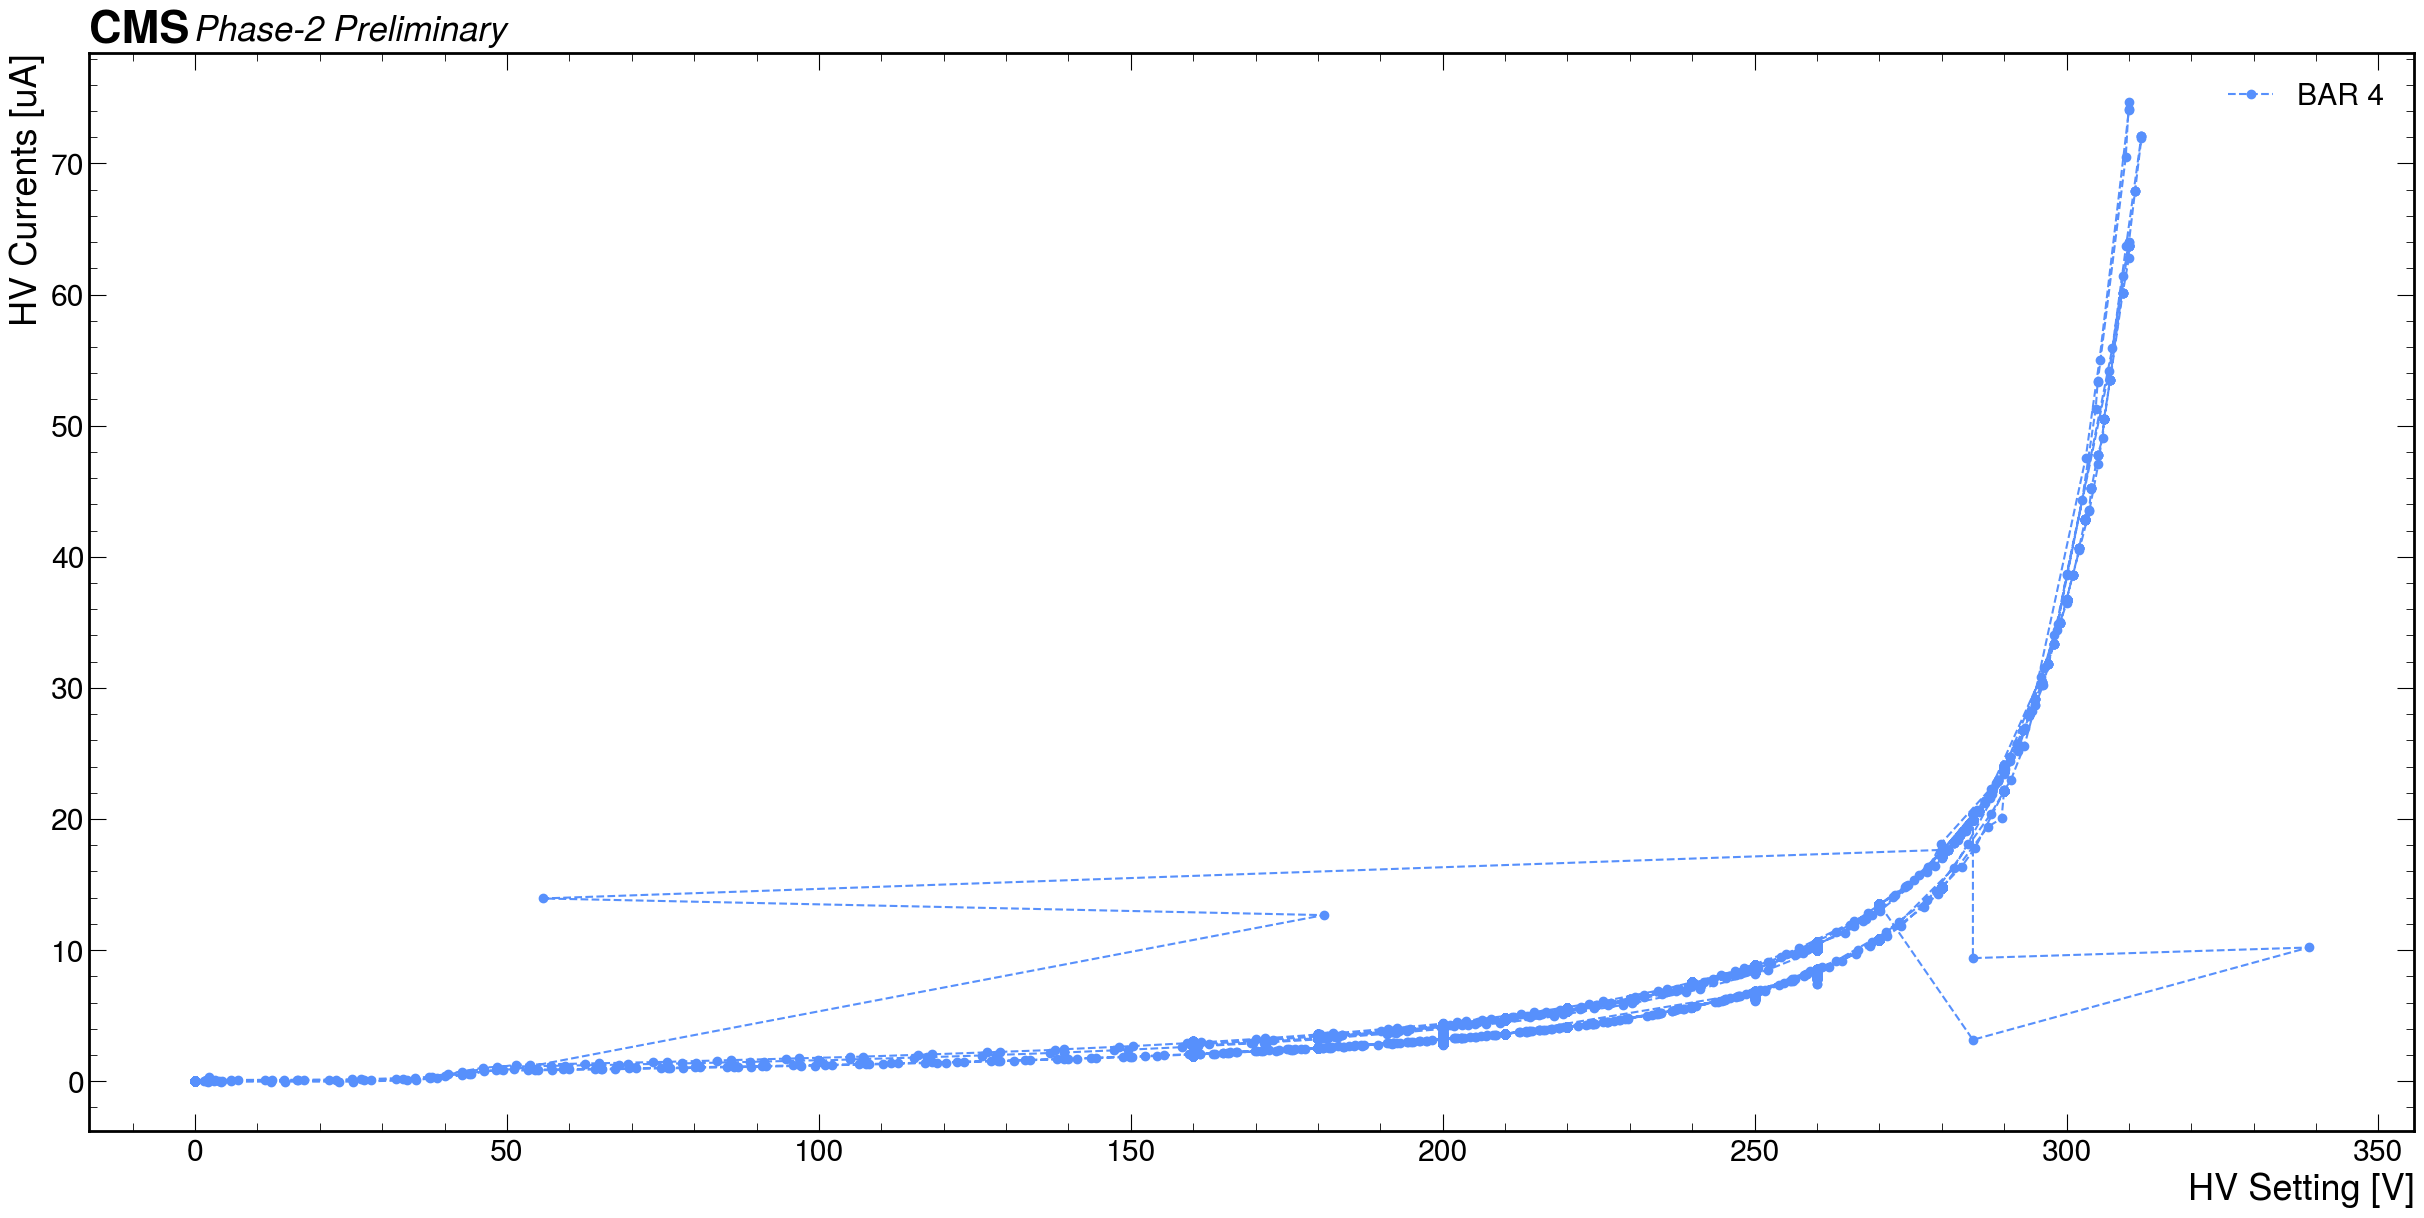

In [173]:
names = ['BAR 4', 'BAR 12', 'BAR 13', 'BB 1-3']

fig, ax = plt.subplots(figsize=(30, 14))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

for idx, iname in enumerate(names):
    if(idx!=0):continue
    ax.plot(-1*hv_info[idx]['terminalV'], -1*hv_info[idx]['currents'], "--o", label=iname)

ax.legend(loc='best')
ax.set_ylabel('HV Currents [uA]')
ax.set_xlabel('HV Setting [V]')

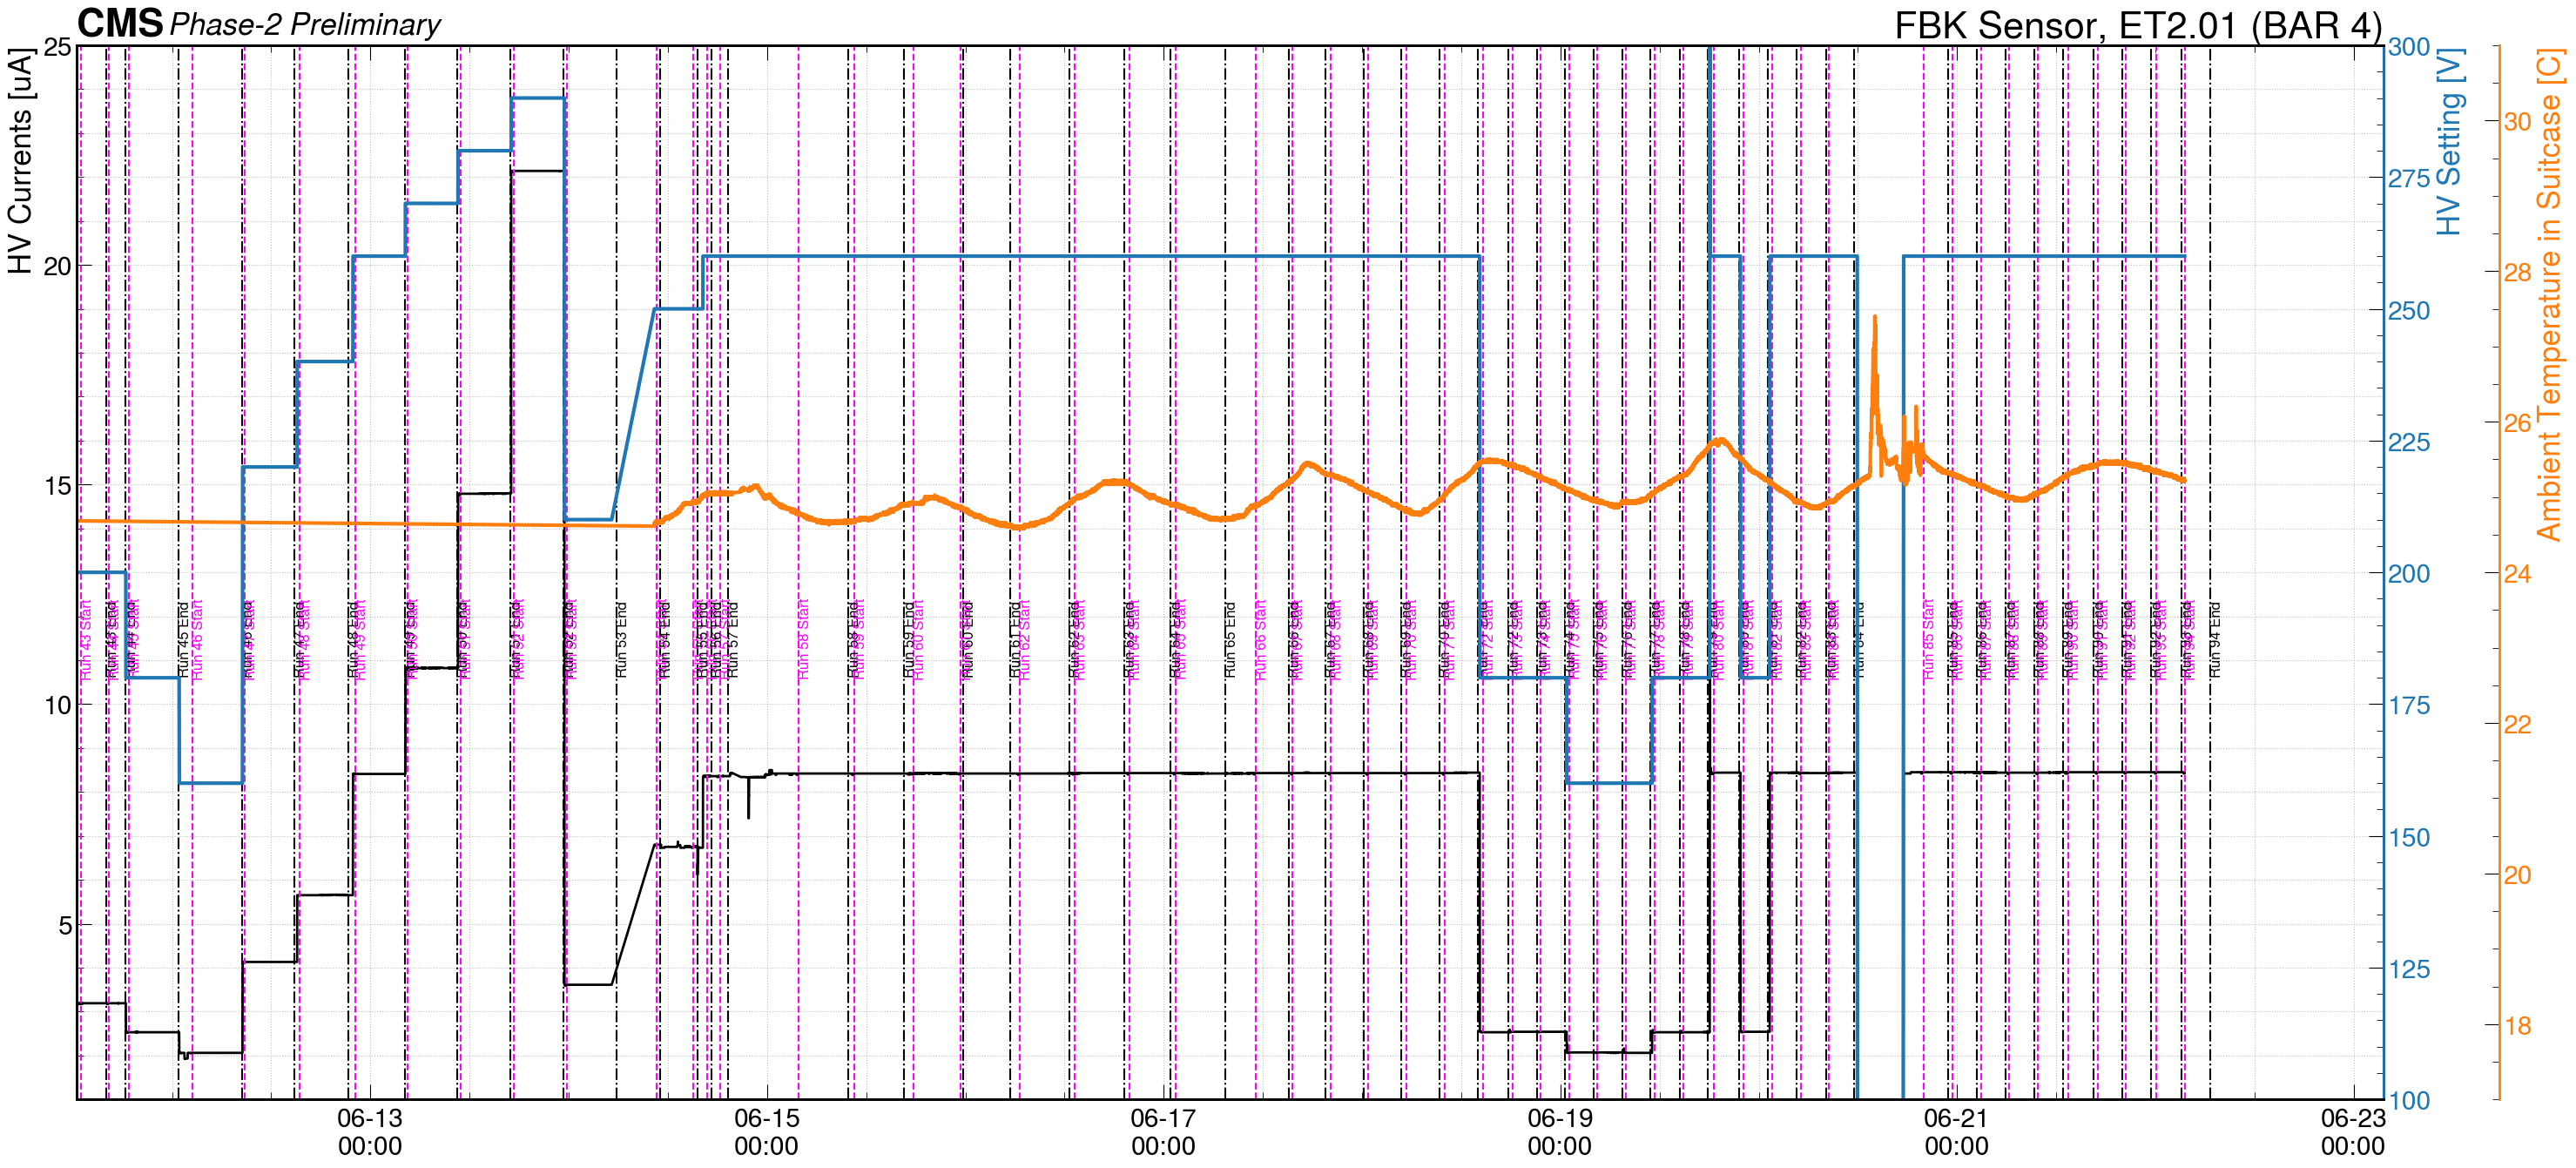

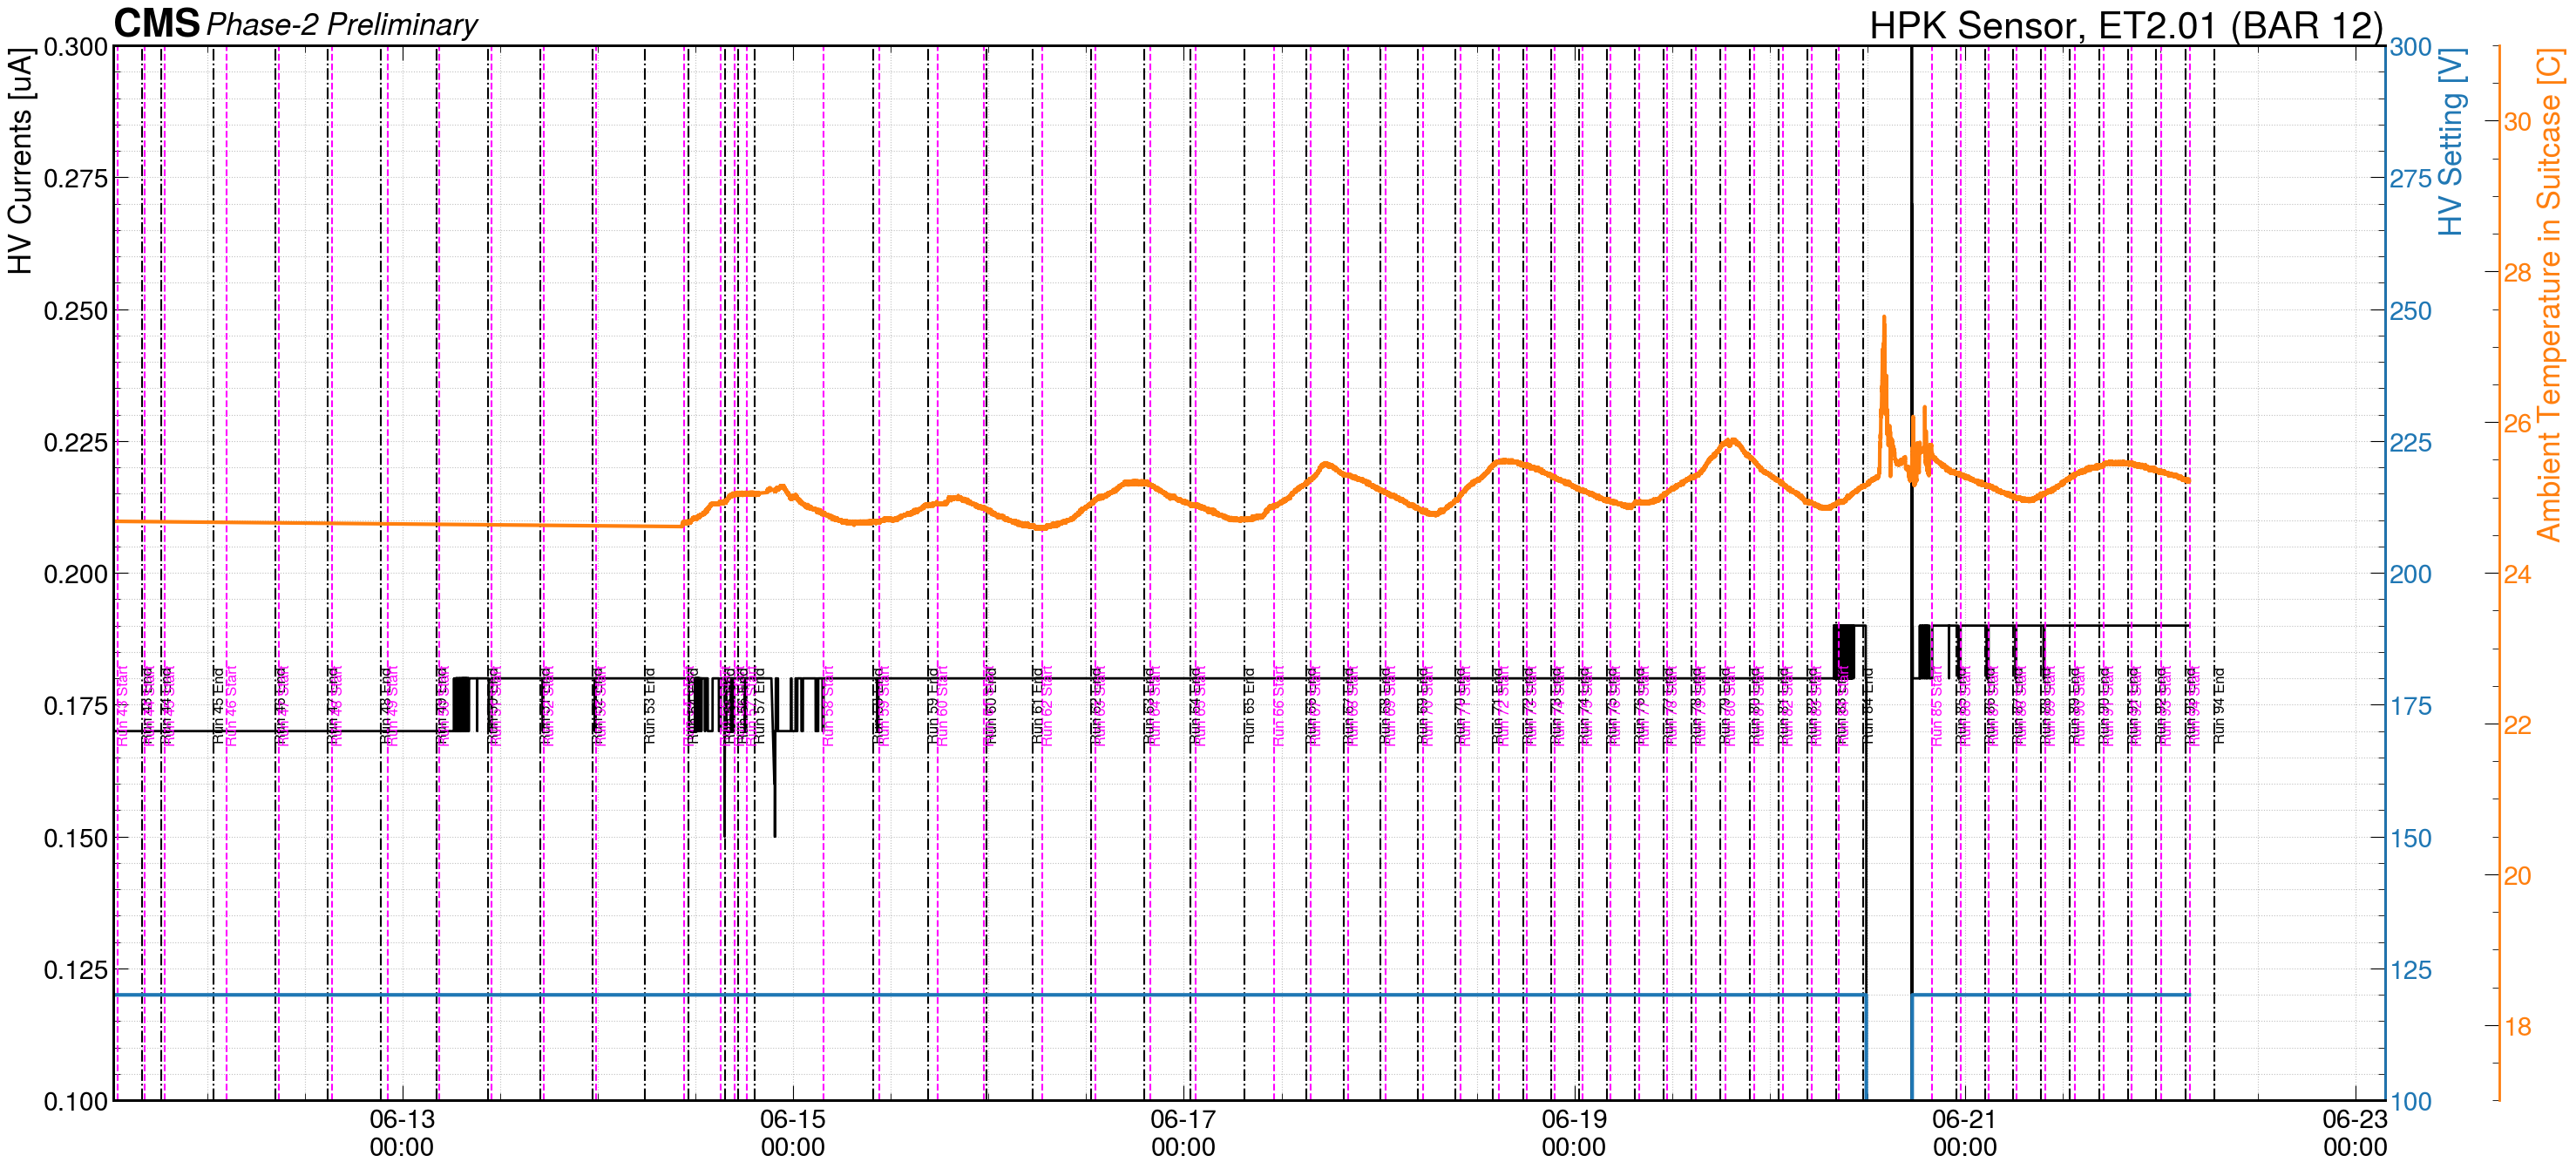

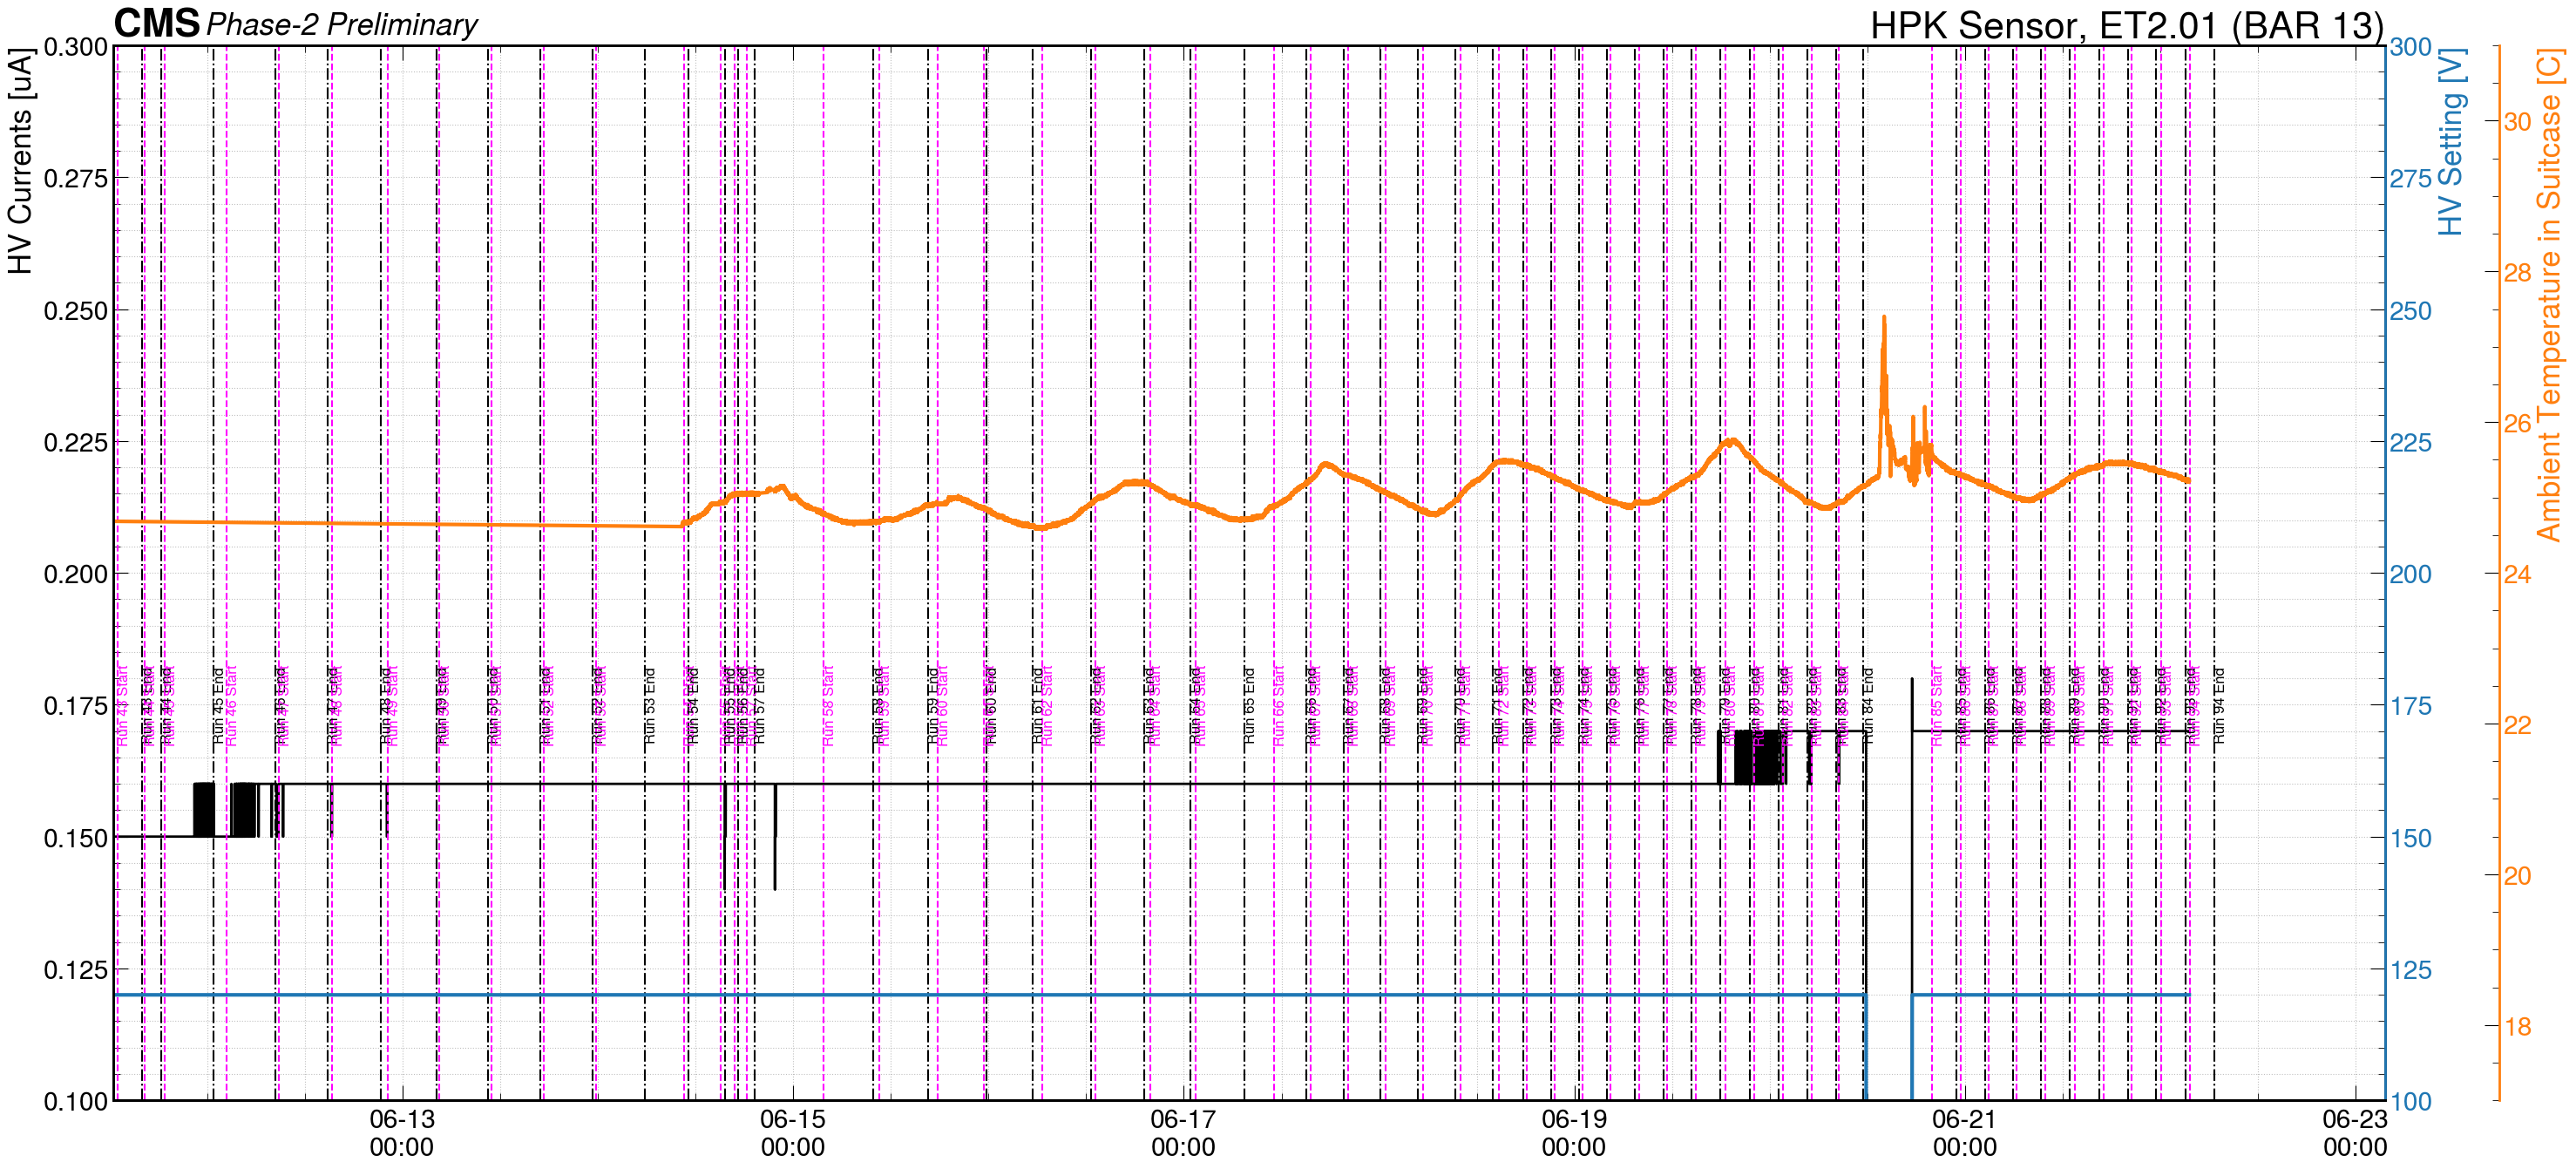

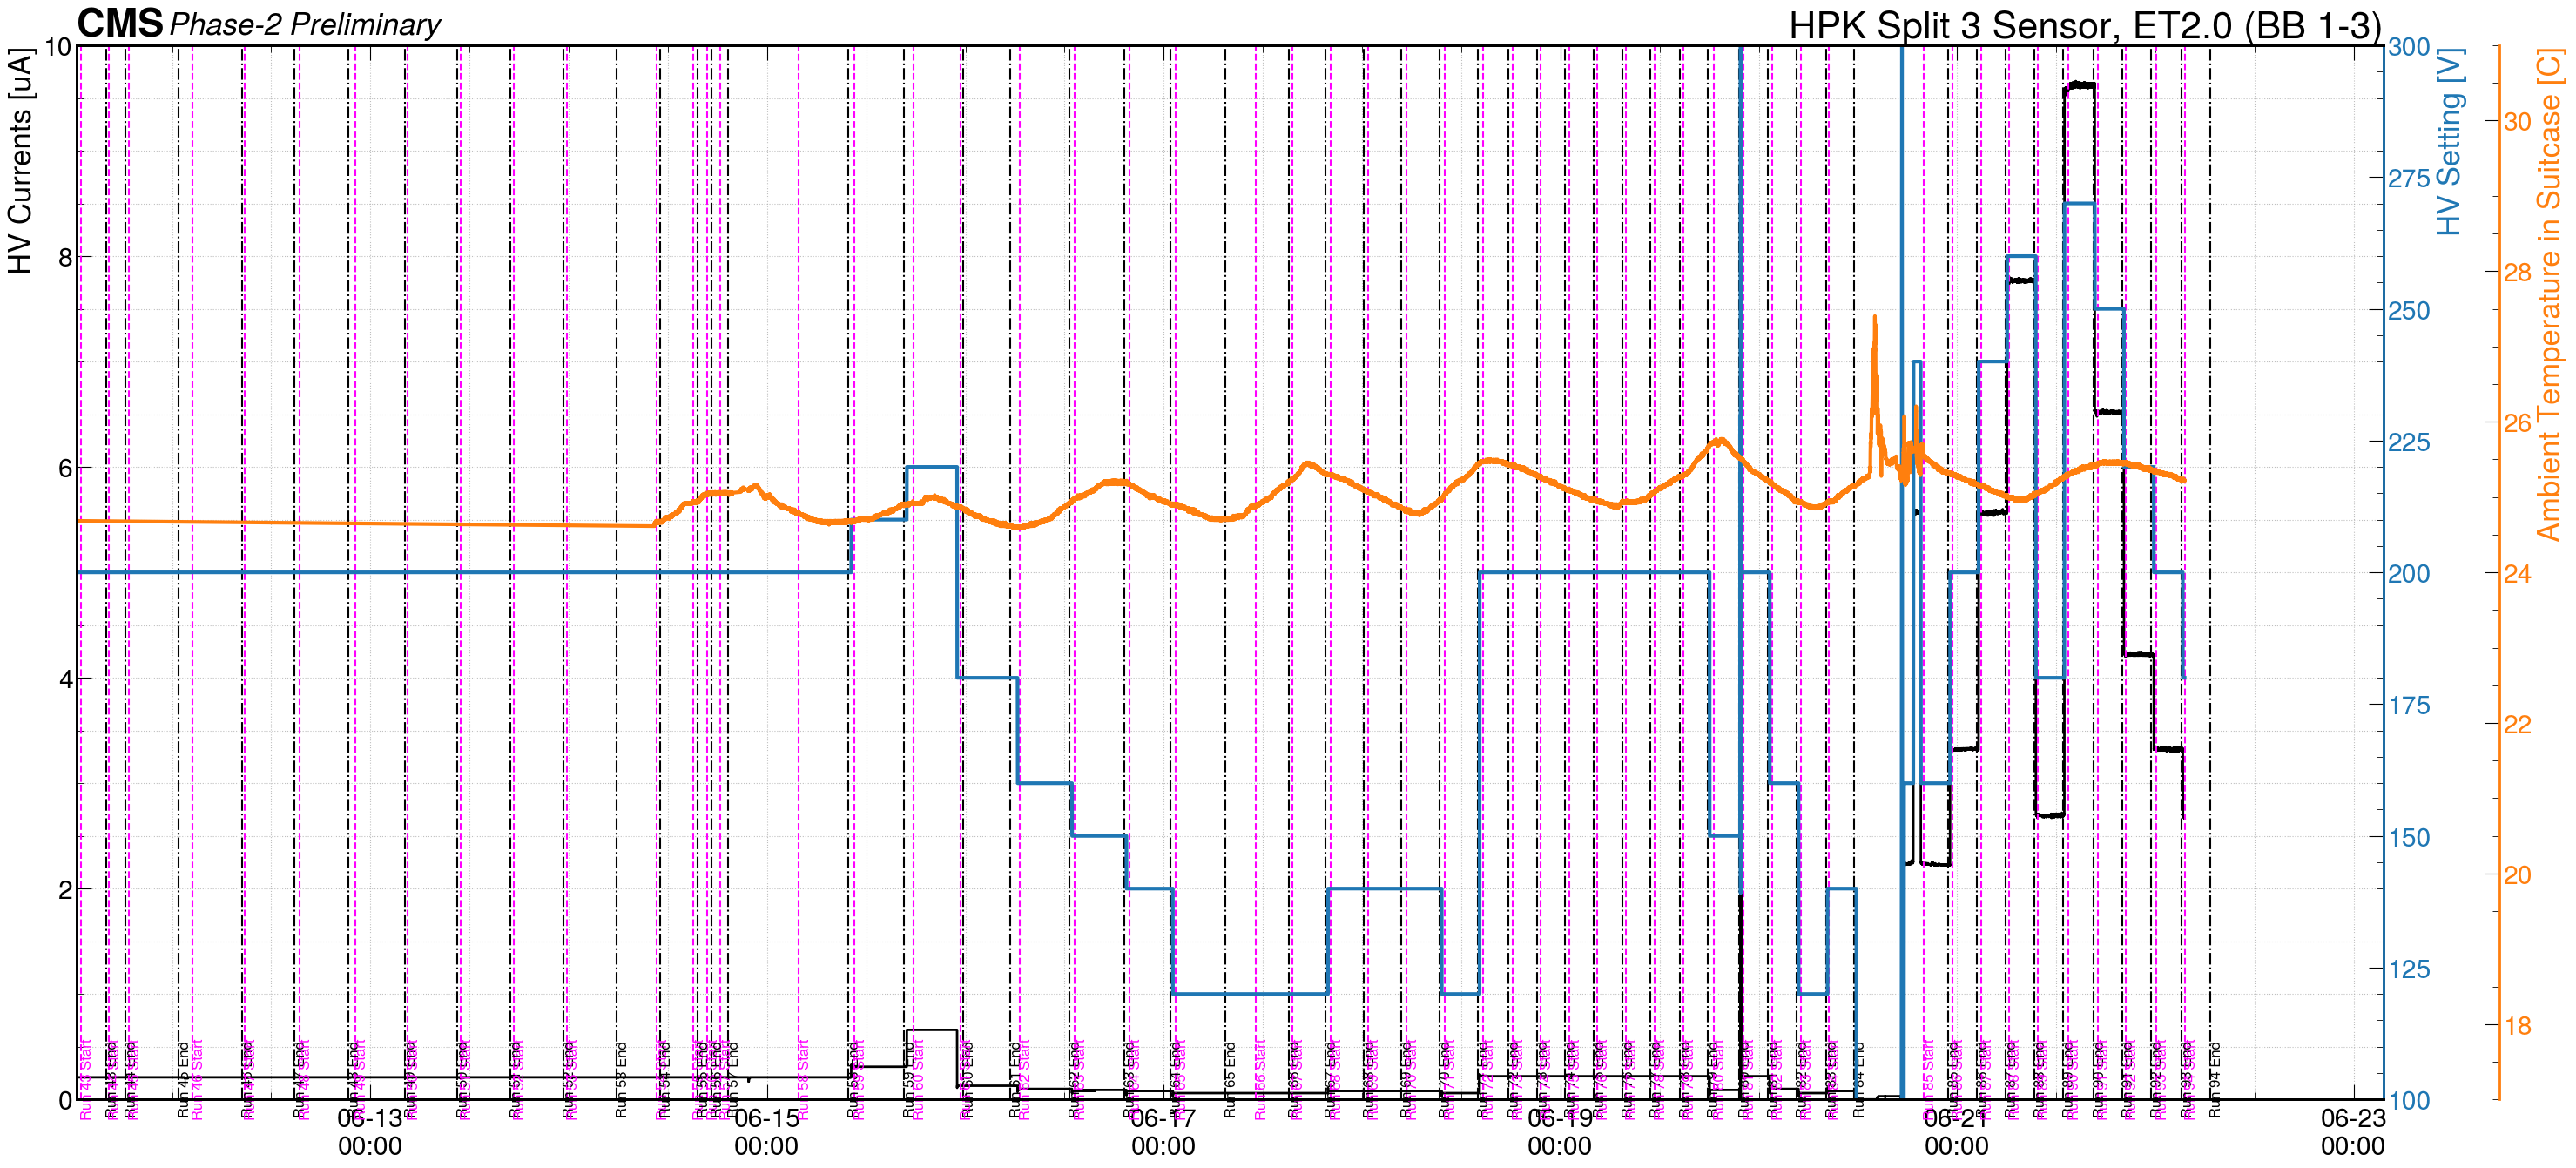

In [174]:
names = ['FBK Sensor, ET2.01 (BAR 4)','HPK Sensor, ET2.01 (BAR 12)','HPK Sensor, ET2.01 (BAR 13)','HPK Split 3 Sensor, ET2.0 (BB 1-3)']
lims  = [(25,1,11.5),(.3,.1,.175),(.3,.1,.175),(.7,0,.2)]
lims  = [(25,1,11.5),(.3,.1,.175),(.3,.1,.175),(10,0,.2)]
idxs  = [0,1,2,3]
left_lim = datetime.datetime(2024, 6, 12, 2, 30)
left_lim = datetime.datetime(2024, 6, 11, 12, 30)
# left_lim = datetime.datetime(2024, 6, 20, 0, 30)
draw_dates = True

for idx, name, lim in zip(idxs, names, lims):

    fig, ax = plt.subplots(figsize=(30, 14))
    hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=iname, color='k', lw=2)

    # ax.legend(loc='best')
    ax.set_ylabel('HV Currents [uA]', fontsize=25)
    ax.set_ylim(top=lim[0], bottom=lim[1])
    ax.set_title(name, loc="right")

    if(draw_dates):
        for index, row in run_time_df.iterrows():
            if(row['Start_Time']>= left_lim): 
                plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed') # - pd.Timedelta(hours=1.2)
                ax.text(x=(row['Start_Time'] ), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
            if(row['End_Time']>= left_lim): 
                plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot') # + pd.Timedelta(hours=1.2)
                ax.text(x=(row['End_Time']), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

    ax2 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('HV Setting [V]', color=color, fontsize=25)
    ax2.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['terminalV'], color=color, lw=3)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines["right"].set_color(color)
    ax2.set_ylim(100, 300)

    ax3 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines.right.set_position(("axes", 1.05))
    color = 'tab:orange'
    ax3.set_ylabel('Ambient Temperature in Suitcase [C]', color=color, fontsize=25)
    ax3.plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'], label=f'{names[idx]}', color=color, lw=3)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_color(color)
    ax3.set_ylim(17, 31)

    ax.grid(which="both")
    ax.set_xlim(left=left_lim)
    plt.tight_layout()
    plt.show()

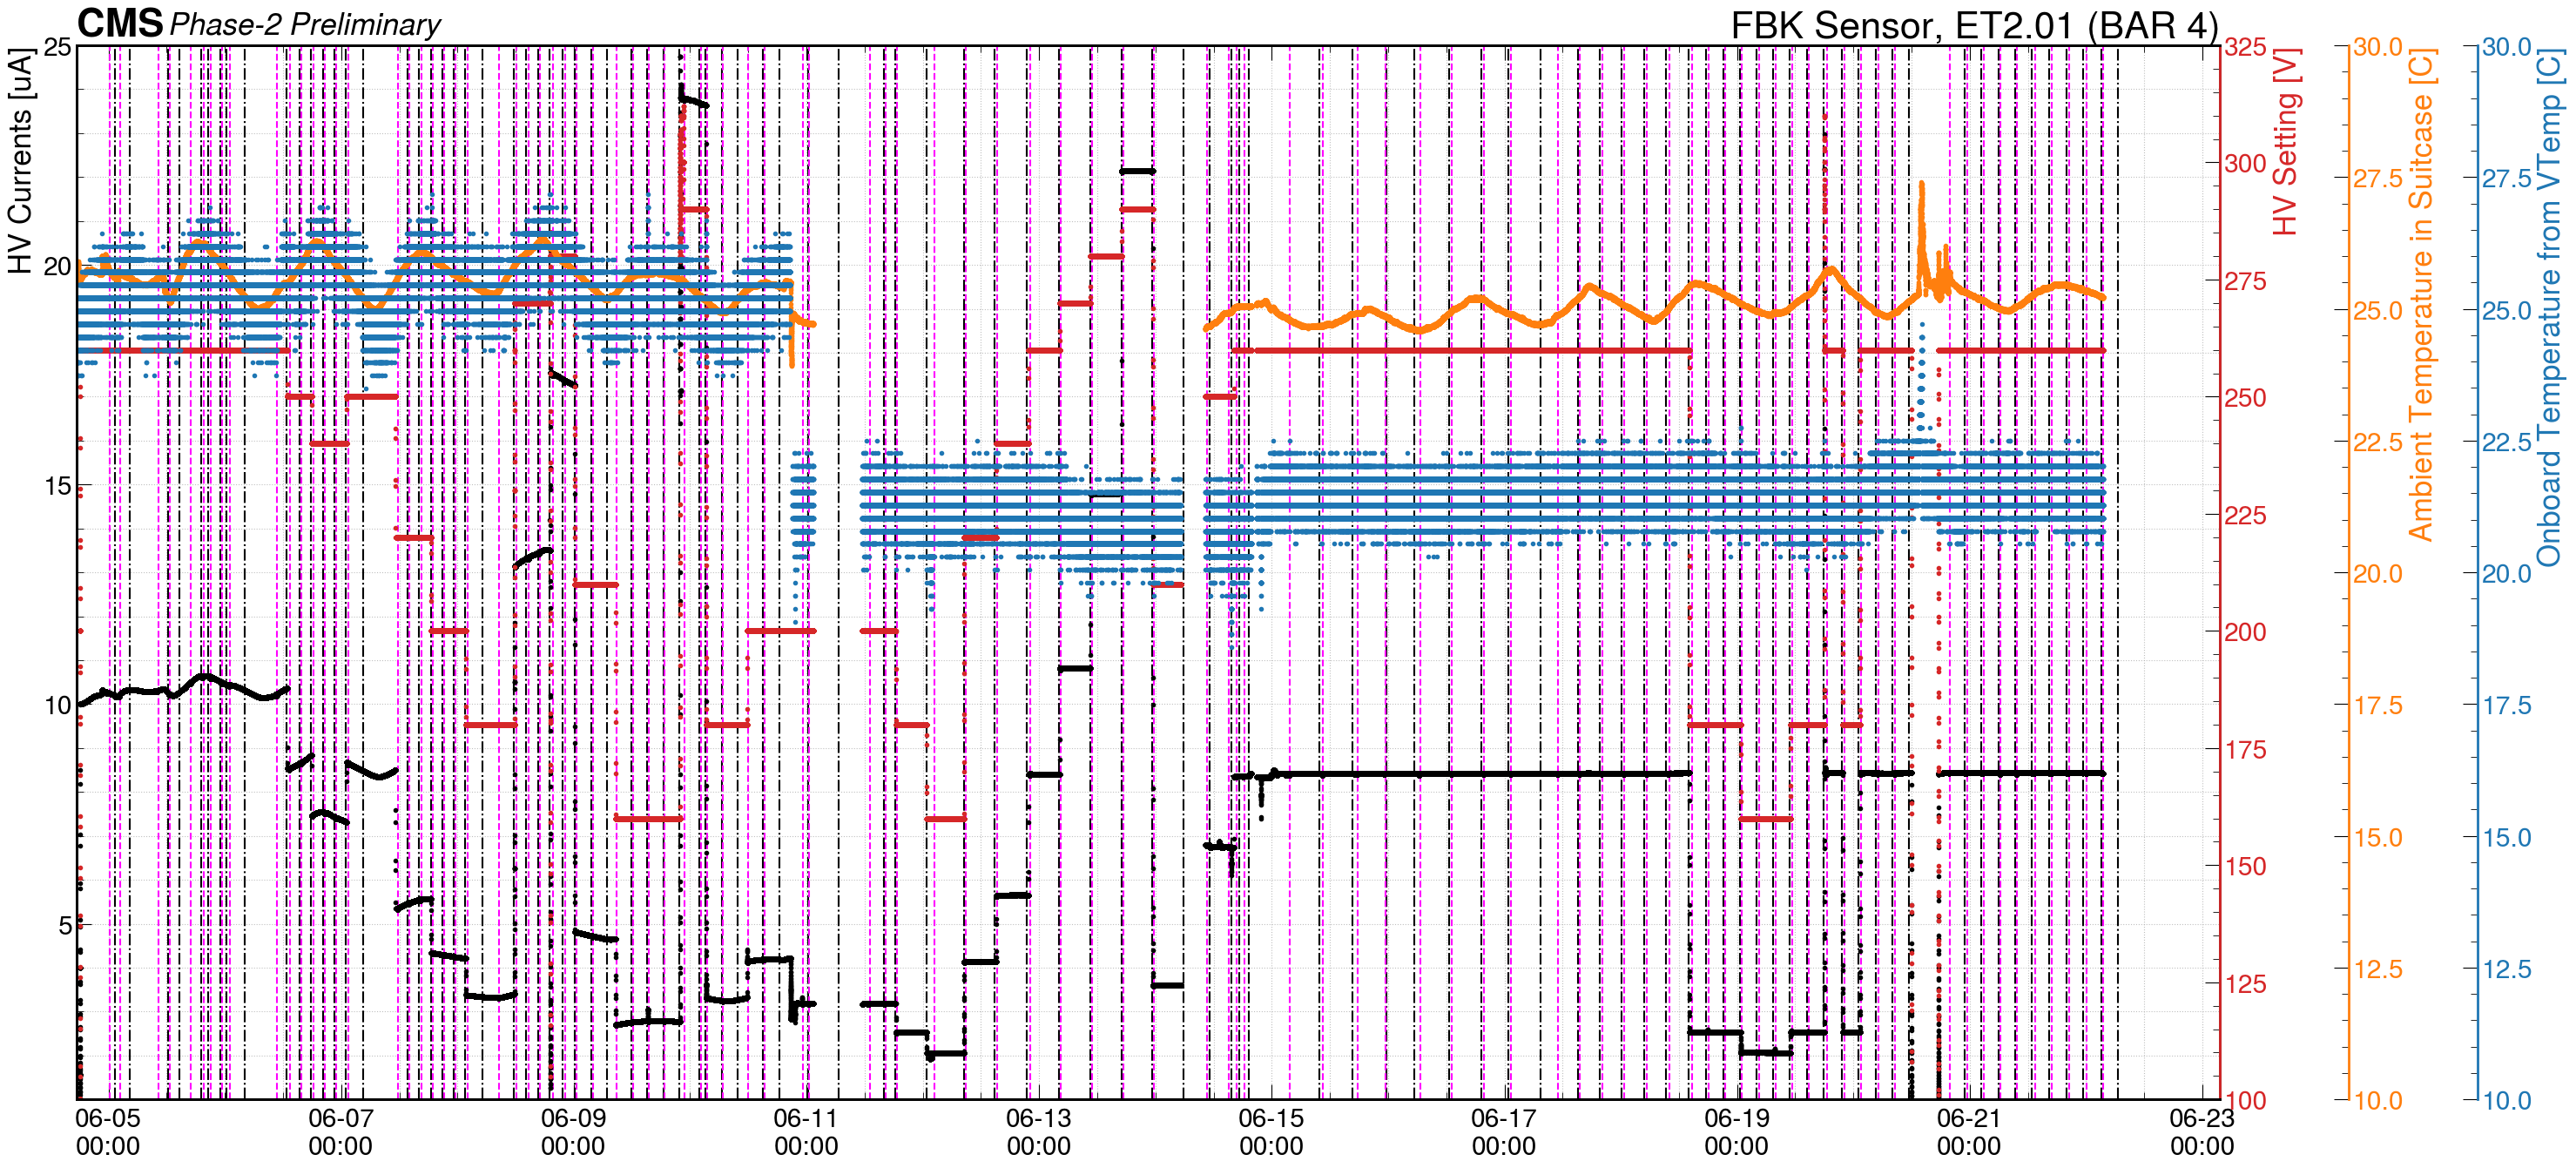

In [175]:
names = ['FBK Sensor, ET2.01 (BAR 4)','HPK Sensor, ET2.01 (BAR 12)','HPK Sensor, ET2.01 (BAR 13)','HPK Split 3 Sensor, ET2.0 (BB 1-3)']
lims  = [(25,1,11.5),(.3,.1,.175),(.3,.1,.175),(.6,.1,.2)]
idxs  = [0,1,2,3]
left_lim = datetime.datetime(2024, 6, 4, 17, 30)
draw_dates = True

for idx, name, lim in zip(idxs[0:1], names[0:1], lims[0:1]):

    fig, ax = plt.subplots(figsize=(30, 14))
    hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    # ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=iname, color='k', lw=2)

    # ax.legend(loc='best')
    ax.set_ylabel('HV Currents [uA]', fontsize=25)
    ax.set_ylim(top=lim[0], bottom=lim[1])
    ax.set_title(name, loc="right")

    if(draw_dates):
        for index, row in run_time_df.iterrows():
            if(row['Start_Time']>= left_lim): 
                plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed') # - pd.Timedelta(hours=1.2)
                # ax.text(x=(row['Start_Time'] ), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
            if(row['End_Time']>= left_lim): 
                plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot') # + pd.Timedelta(hours=1.2)
                # ax.text(x=(row['End_Time']), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

    ax2 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('HV Setting [V]', color=color, fontsize=25)
    ax2.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['terminalV'],".", color=color, lw=3)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines["right"].set_color(color)
    ax2.set_ylim(100, 325)

    ax3 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines.right.set_position(("axes", 1.06))
    color = 'tab:orange'
    ax3.set_ylabel('Ambient Temperature in Suitcase [C]', color=color, fontsize=25)
    ax3.plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'],".", label=f'{names[idx]}', color=color, lw=3)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_color(color)
    ax3.set_ylim(10, 30)

    ax4 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax4.spines.right.set_position(("axes", 1.12))
    color = 'tab:blue'
    ax4.set_ylabel('Onboard Temperature from VTemp [C]', color=color, fontsize=25)
    tmp_df = adc_df.loc[adc_df['channel']==sorted(adc_df['channel'].unique())[idx]]
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
    tmp_df = tmp_df.loc[tmp_df['timestamp']>pd.to_datetime('2024-06-04 17:00:00')]
    ax4.plot(tmp_df['timestamp'], (402.19*tmp_df['voltage']) - 207.81,".", label=f'{names[idx]}', color=color)
    ax4.tick_params(axis='y', labelcolor=color)
    ax4.spines["right"].set_color(color)
    ax4.set_ylim(10, 30)

    ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'],".", label=iname, color='k', lw=2)
    ax.grid(which="both")
    ax.set_xlim(left=left_lim)
    plt.tight_layout()
    plt.show()

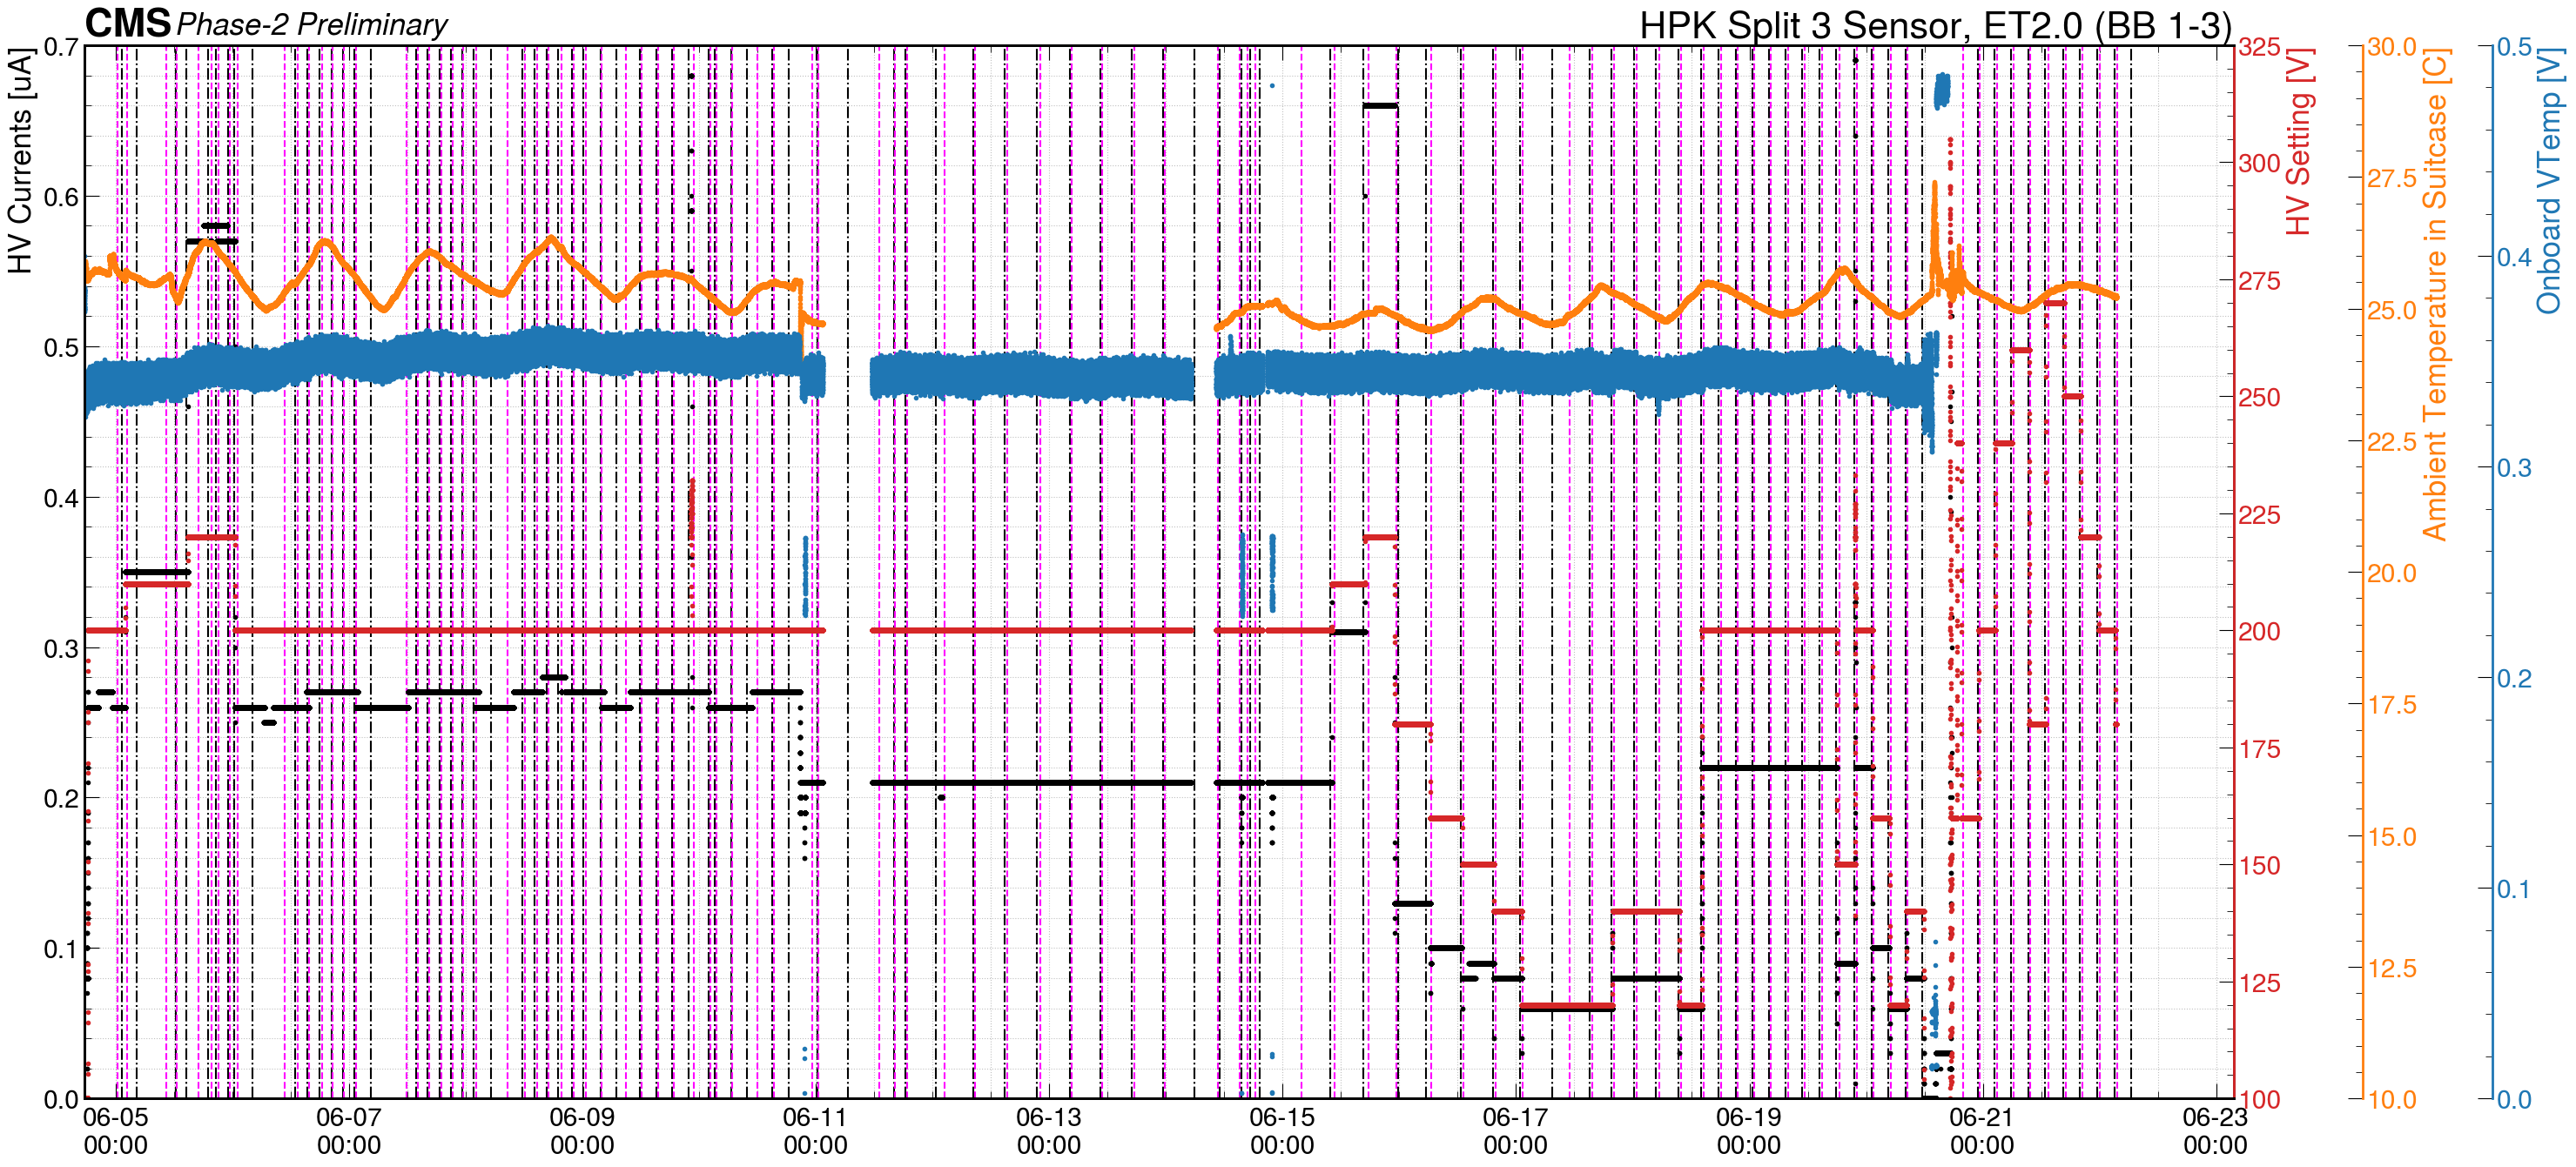

In [176]:
names = ['FBK Sensor, ET2.01 (BAR 4)','HPK Sensor, ET2.01 (BAR 12)','HPK Sensor, ET2.01 (BAR 13)','HPK Split 3 Sensor, ET2.0 (BB 1-3)']
lims  = [(25,1,11.5),(.3,.1,.175),(.3,.1,.175),(.7,.0,.2)]
idxs  = [0,1,2,3]
left_lim = datetime.datetime(2024, 6, 4, 17, 30)
draw_dates = True

for idx, name, lim in zip(idxs[-1:], names[-1:], lims[-1:]):

    fig, ax = plt.subplots(figsize=(30, 14))
    hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)

    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    # ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'], label=iname, color='k', lw=2)

    # ax.legend(loc='best')
    ax.set_ylabel('HV Currents [uA]', fontsize=25)
    ax.set_ylim(top=lim[0], bottom=lim[1])
    ax.set_title(name, loc="right")

    if(draw_dates):
        for index, row in run_time_df.iterrows():
            if(row['Start_Time']>= left_lim): 
                plt.axvline(x=row['Start_Time'], color='magenta', linestyle='dashed') # - pd.Timedelta(hours=1.2)
                # ax.text(x=(row['Start_Time'] ), y=lim[2], s=f"Run {row['Run']} Start", rotation=90, va='center', fontsize=12, color='magenta')
            if(row['End_Time']>= left_lim): 
                plt.axvline(x=row['End_Time'], color='black', linestyle='dashdot') # + pd.Timedelta(hours=1.2)
                # ax.text(x=(row['End_Time']), y=lim[2], s=f"Run {row['Run']} End", rotation=90, va='center', fontsize=12)

    ax2 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('HV Setting [V]', color=color, fontsize=25)
    ax2.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['terminalV'],".", color=color, lw=3)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines["right"].set_color(color)
    ax2.set_ylim(100, 325)

    ax3 = ax.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines.right.set_position(("axes", 1.06))
    color = 'tab:orange'
    ax3.set_ylabel('Ambient Temperature in Suitcase [C]', color=color, fontsize=25)
    ax3.plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'],".", label=f'{names[idx]}', color=color, lw=3)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_color(color)
    ax3.set_ylim(10, 30)

    ax4 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax4.spines.right.set_position(("axes", 1.12))
    color = 'tab:blue'
    ax4.set_ylabel('Onboard VTemp [V]', color=color, fontsize=25)
    tmp_df = adc_df.loc[adc_df['channel']==sorted(adc_df['channel'].unique())[idx]]
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
    tmp_df = tmp_df.loc[tmp_df['timestamp']>pd.to_datetime('2024-06-04 17:00:00')]
    ax4.plot(tmp_df['timestamp'], tmp_df['voltage'],".", label=f'{names[idx]}', color=color)
    ax4.tick_params(axis='y', labelcolor=color)
    ax4.spines["right"].set_color(color)
    ax4.set_ylim(0, 0.5)

    ax.plot(hv_info[idx]['timestamp'], -1*hv_info[idx]['currents'],".", label=iname, color='k', lw=2)
    ax.grid(which="both")
    ax.set_xlim(left=left_lim)
    plt.tight_layout()
    plt.show()